In [1]:
!pip install yfinance

In [13]:
from sklearn.metrics import mean_squared_error


In [2]:
import yfinance as yf
import pandas as pd

# List of stock tickers
tickers = ["AAPL", "AMD", "NVDA", "TSM", "GOOG", "MSFT", "AMZN", "META", "TSLA", "QCOM"]

# Fetch historical stock data (last 3 years)
data = yf.download(tickers, period="3y", interval="1d")




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed

CSV file 'tech_stocks_closing_prices.csv' created successfully!


In [24]:
from pickle import NONE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

class StockLSTM:
    def __init__(self, data, sequence_length=60):
        """
        Initializes the LSTM model for stock prediction.

        :param data: DataFrame containing the closing prices.
        :param sequence_length: Number of past days to use for prediction.
        """
        self.data = data  # Original data
        self.sequence_length = sequence_length  # Number of past days for prediction
        self.scaler = MinMaxScaler(feature_range=(0,1))  # Normalization
        self.model = None  # Placeholder for the LSTM model
        self.history = None  # Placeholder for training history
        self.predictions = None
        self.y_test_actual = None

        # Preprocess the data
        self.preprocess_data()

    def preprocess_data(self):
        """Scales data and prepares training and testing sets."""
        self.scaled_data = self.scaler.fit_transform(self.data.values.reshape(-1,1))
        self.X, self.y = self.create_sequences(self.scaled_data)

        # Split dataset: 80% training, 20% testing
        train_size = int(len(self.X) * 0.8)
        self.X_train, self.y_train = self.X[:train_size], self.y[:train_size]
        self.X_test, self.y_test = self.X[train_size:], self.y[train_size:]

    def create_sequences(self, data):
        """
        Converts time-series data into sequences for LSTM input.

        :param data: Scaled time-series data
        :return: X (features) and y (target)
        """
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i+self.sequence_length])
            y.append(data[i+self.sequence_length])
        return np.array(X), np.array(y)

    def build_model(self):
        """Defines and compiles the LSTM model."""
        self.model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(self.sequence_length, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        self.model.compile(optimizer="adam", loss="mean_squared_error")

    def train_model(self, epochs=50, batch_size=32):
        """
        Trains the LSTM model.

        :param epochs: Number of epochs to train.
        :param batch_size: Batch size for training.
        """
        if self.model is None:
            self.build_model()

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        self.history = self.model.fit(
            self.X_train, self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(self.X_test, self.y_test),
            callbacks=[early_stopping]
        )

    def evaluate_model(self):
        """Evaluates model performance and plots training history."""
        plt.figure(figsize=(10,5))
        plt.plot(self.history.history['loss'], label="Training Loss", color="blue")
        plt.plot(self.history.history['val_loss'], label="Validation Loss", color="red", linestyle="dashed")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("LSTM Training & Validation Loss")
        plt.legend()
        plt.show()

    def predict_test_set(self):
        """Predicts values for the test set and compares with actual prices."""
        # Generate predictions
        self.predictions = self.model.predict(self.X_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)

        # Store actual test values
        self.y_test_actual = self.scaler.inverse_transform(self.y_test.reshape(-1,1))

        # Plot actual vs predicted values
        plt.figure(figsize=(12,6))
        plt.plot(self.data.index[-len(self.y_test_actual):], self.y_test_actual,
                label="Actual Prices", color="blue")
        plt.plot(self.data.index[-len(self.predictions):], self.predictions,
                label="Predicted Prices", linestyle="dashed", color="red")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title("Stock Price Prediction vs Actual")
        plt.legend()
        plt.show()

        # Return for optional usage
        return self.predictions, self.y_test_actual


    def forecast_future(self, future_days=7):
        """
        Predicts future stock prices.

        :param future_days: Number of days to forecast
        :return: Future dates and predicted prices
        """
        future_predictions = []
        last_sequence = self.scaled_data[-self.sequence_length:]

        for _ in range(future_days):
            next_prediction = self.model.predict(last_sequence.reshape(1, self.sequence_length, 1))
            future_predictions.append(next_prediction[0, 0])
            last_sequence = np.roll(last_sequence, -1)
            last_sequence[-1] = next_prediction

        future_predictions = self.scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        future_dates = pd.date_range(self.data.index[-1], periods=future_days+1, freq='B')[1:]

        # Plot future predictions
        plt.figure(figsize=(12,6))
        plt.plot(self.data.index[-100:], self.data[-100:], label="Actual Prices", color="blue")
        plt.plot(future_dates, future_predictions, label="Predicted Prices (Next 7 Days)", linestyle="dashed", color="green")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title("Stock Price: 7-Day Forecast")
        plt.legend()
        plt.show()

        return future_dates, future_predictions

    def compute_rmse(self):

        """Computes RMSE (Root Mean Squared Error) between actual and predicted prices."""
        rmse = np.sqrt(mean_squared_error(self.y_test_actual, self.predictions))
        print(f"RMSE: {rmse:.2f}")
        return rmse

    def print_predicted_vs_actual(self, n_days=10):
        """
        Prints the predicted vs actual prices for the last `n_days`.

        :param n_days: Number of days to print the comparison
        """
        print("\nPredicted vs Actual Prices:")
        print(f"{'Date':<12}{'Actual Price':<15}{'Predicted Price'}")
        print("-" * 40)

        test_dates = self.data.index[-len(self.y_test_actual):]
        for i in range(-n_days, 0):
            date = test_dates[i].strftime("%Y-%m-%d")
            actual = round(self.y_test_actual[i][0], 2)
            predicted = round(self.predictions[i][0], 2)
            print(f"{date:<12}{actual:<15}{predicted}")

    def forecast_future(self, future_days=7):
        """
        Predicts future stock prices.

        :param future_days: Number of days to forecast
        :return: Future dates and predicted prices
        """
        future_predictions = []
        last_sequence = self.scaled_data[-self.sequence_length:]

        for _ in range(future_days):
            next_prediction = self.model.predict(last_sequence.reshape(1, self.sequence_length, 1))
            future_predictions.append(next_prediction[0, 0])
            last_sequence = np.roll(last_sequence, -1)
            last_sequence[-1] = next_prediction

        future_predictions = self.scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        future_dates = pd.date_range(self.data.index[-1], periods=future_days+1, freq='B')[1:]

        # Plot future predictions
        plt.figure(figsize=(12,6))
        plt.plot(self.data.index[-100:], self.data[-100:], label="Actual Prices", color="blue")
        plt.plot(future_dates, future_predictions, label="Predicted Prices (Next 7 Days)", linestyle="dashed", color="green")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title("Stock Price: 7-Day Forecast")
        plt.legend()
        plt.show()

        return future_dates, future_predictions

    def save_model(self, filename="lstm_stock_model.h5"):
        """Saves the trained model."""
        self.model.save(filename)
        print(f"Model saved as {filename}")

    def load_model(self, filename="lstm_stock_model.h5"):
        """Loads a previously saved model."""
        from tensorflow.keras.models import load_model
        self.model = load_model(filename)
        print(f"Model loaded from {filename}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0423 - val_loss: 0.0435
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_l

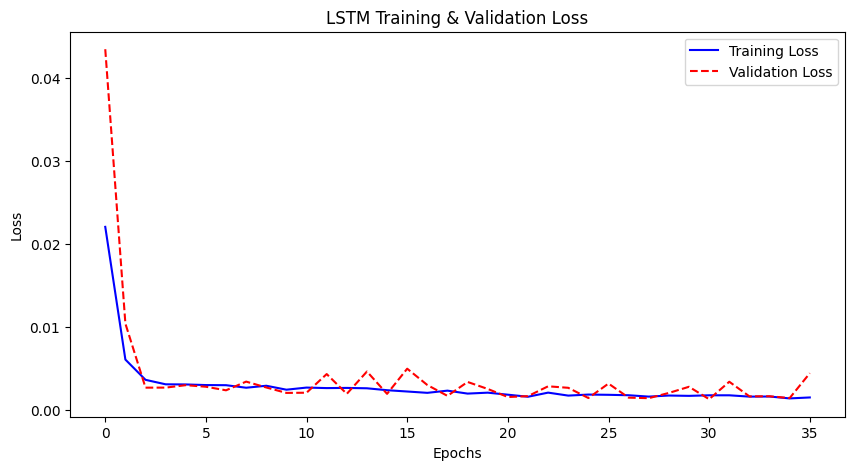

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


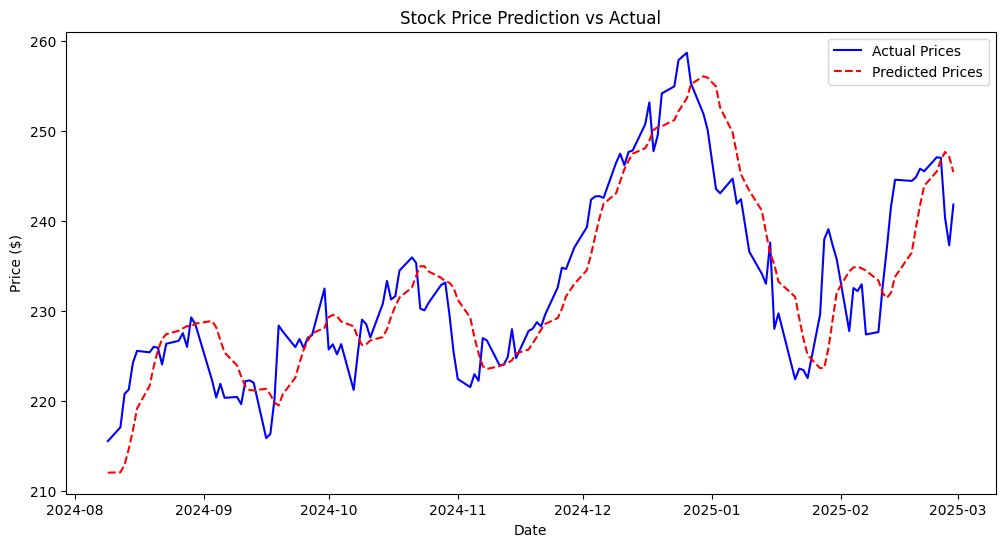

(array([[211.99545],
        [212.0427 ],
        [212.88785],
        [214.63284],
        [216.70638],
        [219.14847],
        [221.65613],
        [223.82735],
        [225.60541],
        [226.88773],
        [227.41508],
        [227.79742],
        [228.05722],
        [228.31837],
        [228.28241],
        [228.58885],
        [228.88255],
        [228.16943],
        [226.74664],
        [225.36703],
        [223.94296],
        [222.71098],
        [221.63339],
        [221.18645],
        [221.15799],
        [221.3366 ],
        [220.68552],
        [219.79225],
        [219.47926],
        [220.74727],
        [222.572  ],
        [224.20958],
        [225.67914],
        [226.6973 ],
        [227.50517],
        [228.1089 ],
        [229.30281],
        [229.56157],
        [229.39622],
        [228.83127],
        [228.29063],
        [227.03484],
        [226.21033],
        [226.27557],
        [226.71829],
        [227.08954],
        [227.96362],
        [229.

In [25]:
# Load AAPL Data
df_aapl_close = data['Close']['AAPL'].reset_index()
df_aapl_close.set_index('Date', inplace=True)

# Initialize LSTM Model
lstm_model = StockLSTM(df_aapl_close)

# Train the model
lstm_model.train_model(epochs=50, batch_size=32)

# Evaluate training performance
lstm_model.evaluate_model()

# Predict and visualize test set results
lstm_model.predict_test_set()


RMSE: 4.87

Predicted vs Actual Prices:
Date        Actual Price   Predicted Price
----------------------------------------
2024-12-16  250.76         248.10000610351562
2024-12-17  253.2          248.94000244140625
2024-12-18  247.78         250.13999938964844
2024-12-19  249.52         250.4600067138672
2024-12-20  254.21         250.55999755859375
2024-12-23  254.99         251.24000549316406
2024-12-24  257.92         252.2100067138672
2024-12-26  258.74         253.66000366210938
2024-12-27  255.31         255.24000549316406
2024-12-30  251.92         256.1199951171875
2024-12-31  250.14         255.9499969482422
2025-01-02  243.58         254.97000122070312
2025-01-03  243.09         252.6300048828125
2025-01-06  244.73         249.86000061035156
2025-01-07  241.94         247.47999572753906
2025-01-08  242.43         245.19000244140625
2025-01-10  236.59         243.3800048828125
2025-01-13  234.14         241.1699981689453
2025-01-14  233.02         238.75
2025-01-15  237.61   

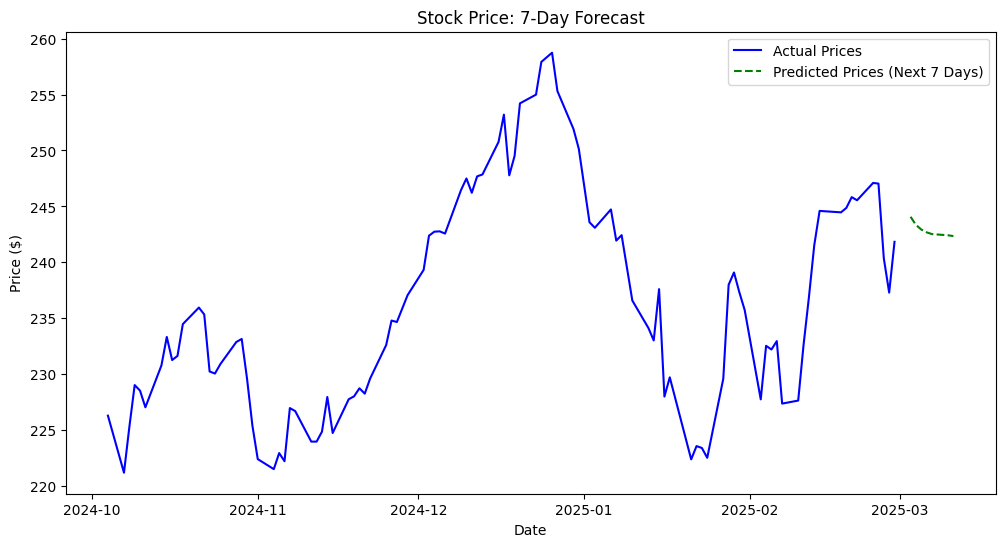

(DatetimeIndex(['2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
                '2025-03-07', '2025-03-10', '2025-03-11'],
               dtype='datetime64[ns]', freq='B'),
 array([[244.07468],
        [243.35078],
        [242.93634],
        [242.68626],
        [242.52719],
        [242.4216 ],
        [242.34982]], dtype=float32))

In [27]:

# Compute RMSE
lstm_model.compute_rmse()

# Print last 10 days of actual vs predicted prices
lstm_model.print_predicted_vs_actual(n_days=50)

# Forecast next 7 days
lstm_model.forecast_future(future_days=7)


[*********************100%***********************]  10 of 10 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM model for AAPL...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0444 - val_loss: 0.0342
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 12/50
18/18 ━━━━━━━━━━━━

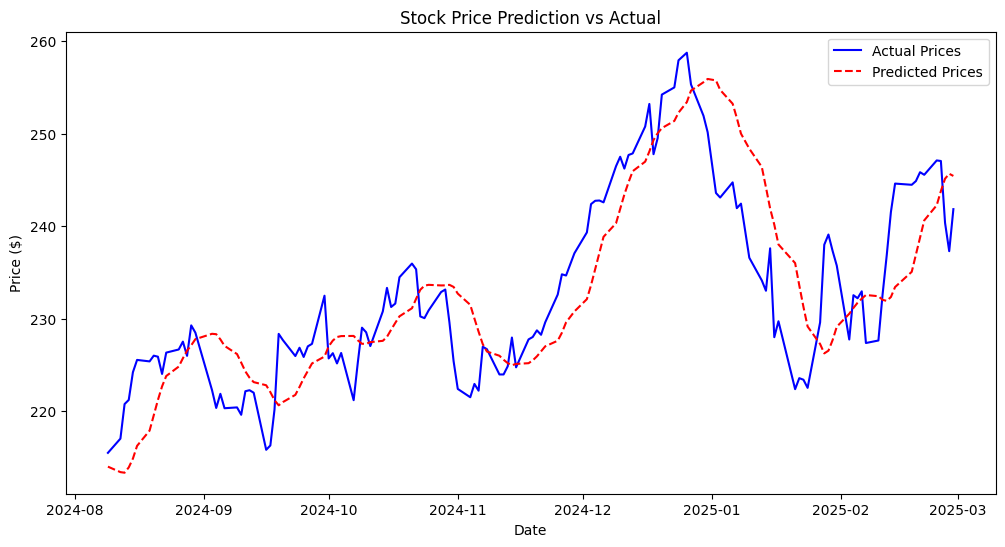

RMSE: 5.92
Model saved as saved_models/lstm_AAPL.h5

Training LSTM model for AMD...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0909 - val_loss: 0.0163
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0131 - val_loss: 0.0026
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_l

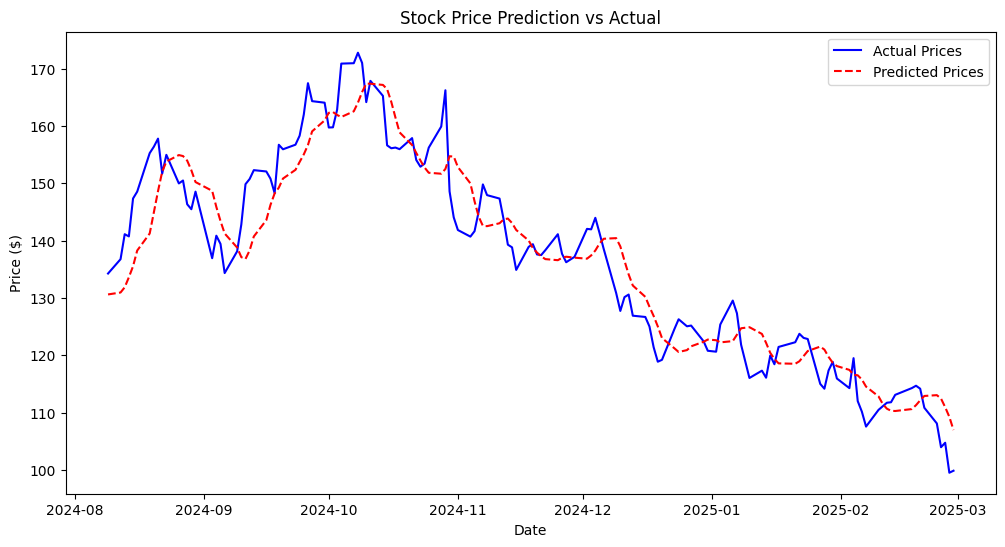

RMSE: 5.95
Model saved as saved_models/lstm_AMD.h5

Training LSTM model for NVDA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0425 - val_loss: 0.0398
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - val_l

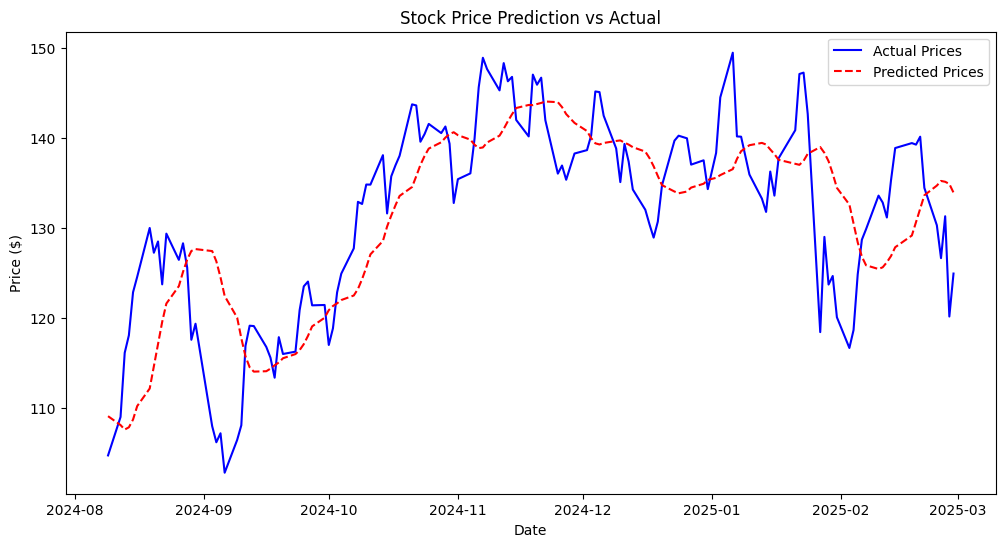

RMSE: 7.68
Model saved as saved_models/lstm_NVDA.h5

Training LSTM model for TSM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0528 - val_loss: 0.0481
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


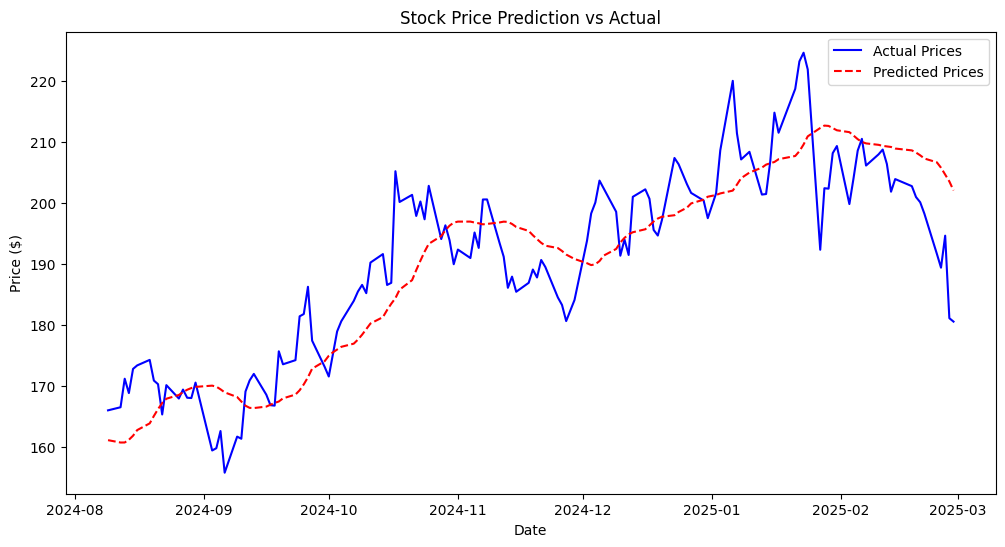

RMSE: 8.17
Model saved as saved_models/lstm_TSM.h5

Training LSTM model for GOOG...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1134 - val_loss: 0.0362
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105 - val_loss: 0.0125
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_l

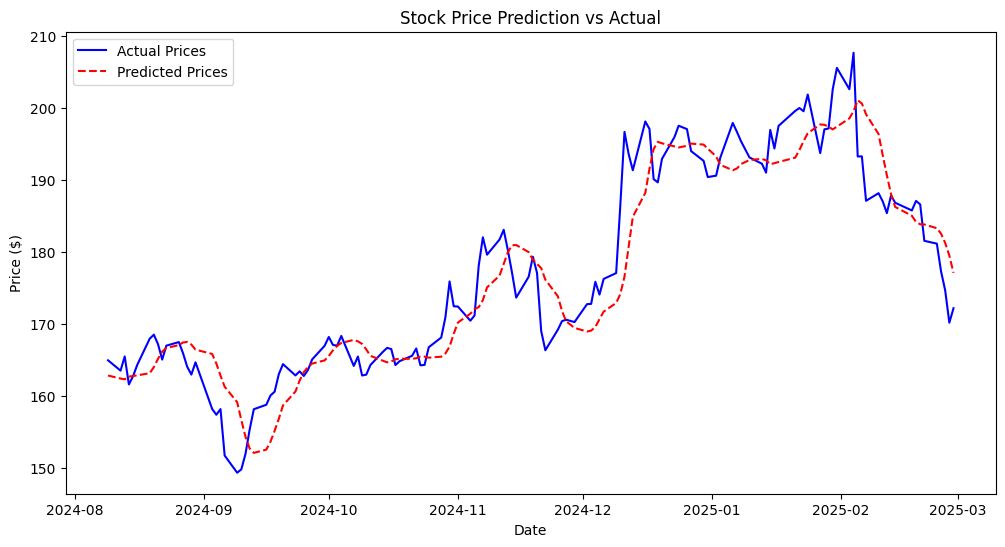

RMSE: 5.05
Model saved as saved_models/lstm_GOOG.h5

Training LSTM model for MSFT...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1108 - val_loss: 0.0481
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166 - val_loss: 0.0035
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_l

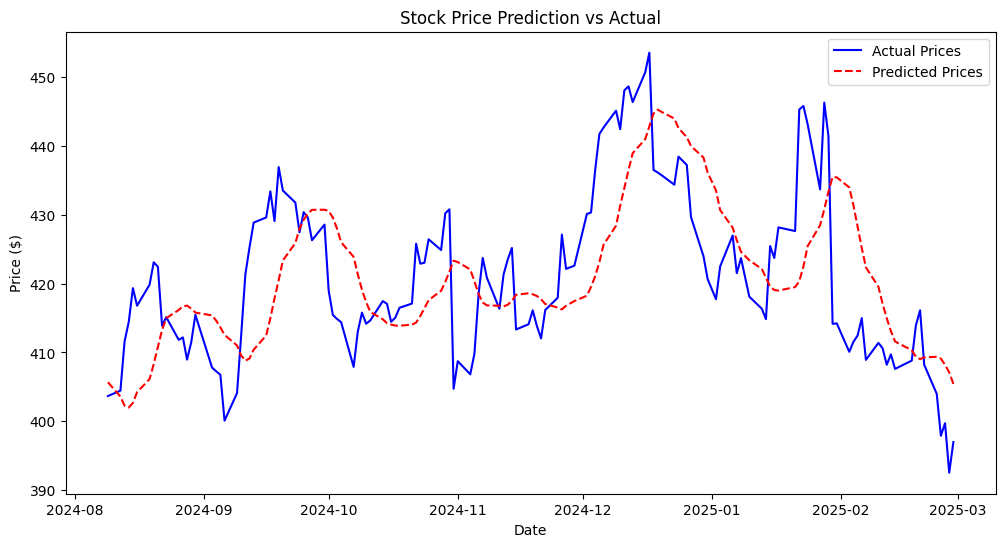

RMSE: 10.48
Model saved as saved_models/lstm_MSFT.h5

Training LSTM model for AMZN...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0588 - val_loss: 0.0622
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


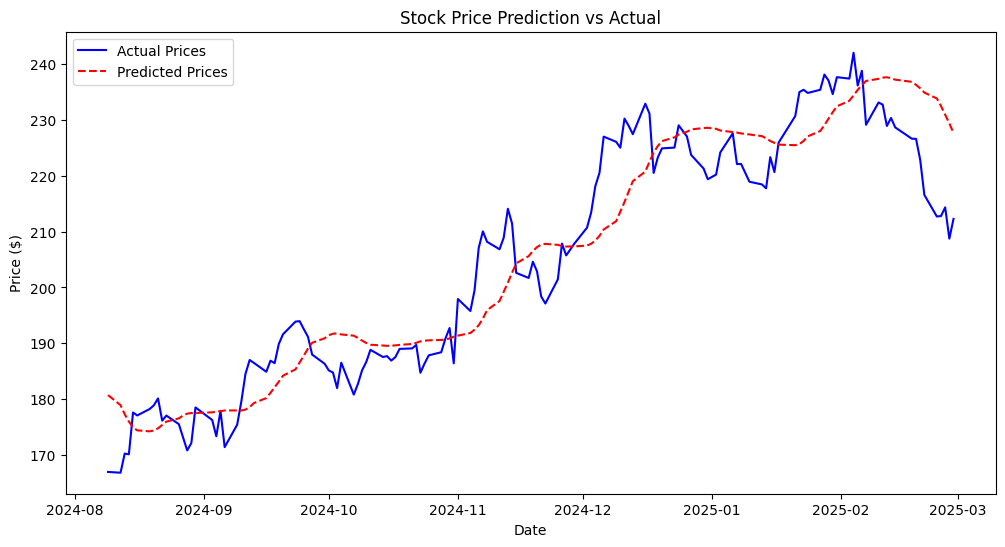

RMSE: 7.86
Model saved as saved_models/lstm_AMZN.h5

Training LSTM model for META...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0435 - val_loss: 0.0507
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_l

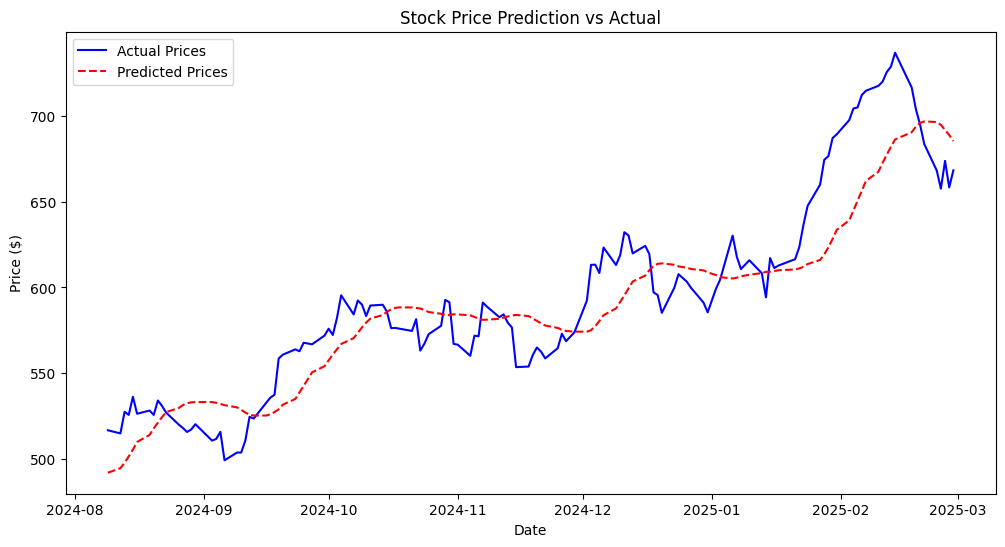

RMSE: 24.78
Model saved as saved_models/lstm_META.h5

Training LSTM model for TSLA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0282 - val_loss: 0.0452
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0060 - val_loss: 0.0283
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045 - val_loss: 0.0150
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0087
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_l

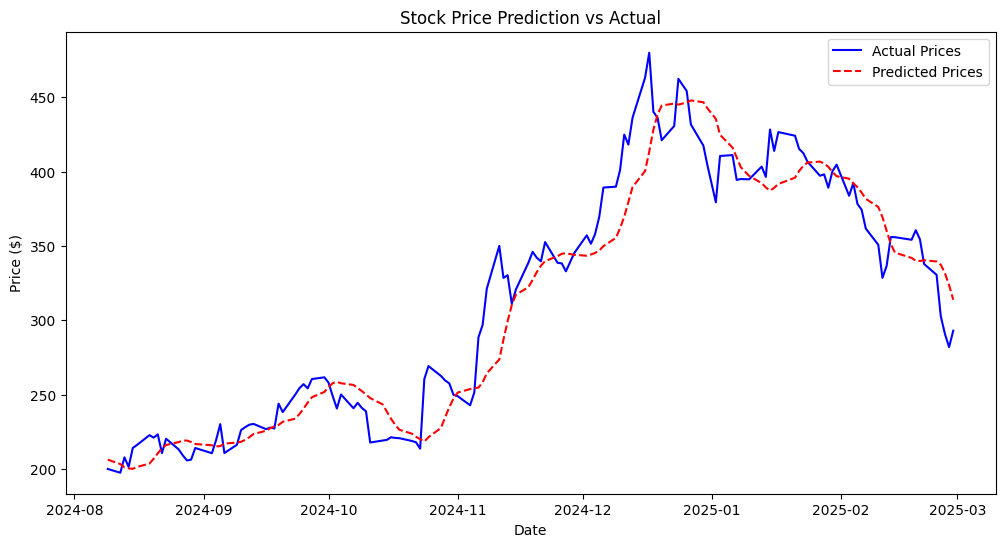

RMSE: 22.67
Model saved as saved_models/lstm_TSLA.h5

Training LSTM model for QCOM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0429 - val_loss: 0.0102
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


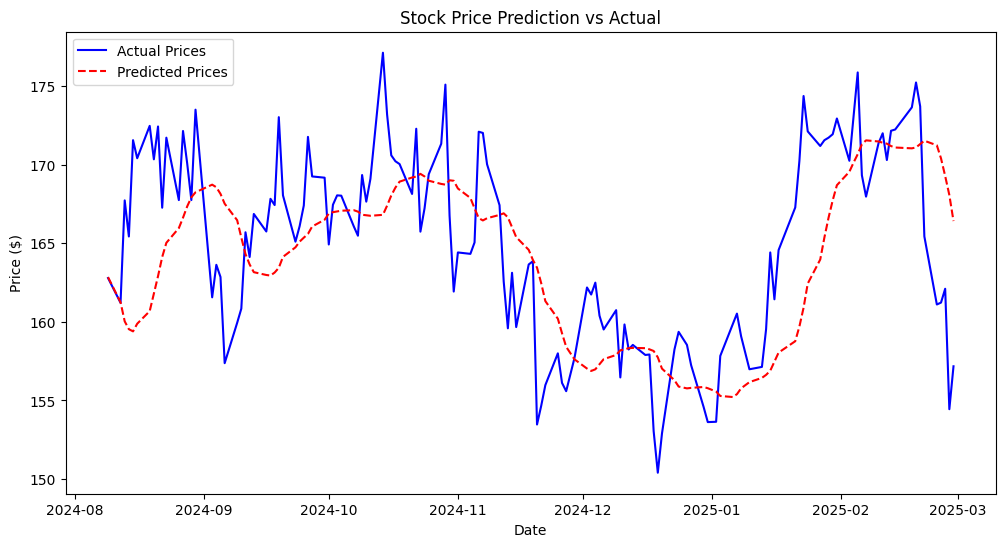

RMSE: 5.15
Model saved as saved_models/lstm_QCOM.h5

✅ Training Complete for All Stocks!


In [32]:
import os
import yfinance as yf
from sklearn.metrics import mean_squared_error

# List of stock tickers
tickers = ["AAPL", "AMD", "NVDA", "TSM", "GOOG", "MSFT", "AMZN", "META", "TSLA", "QCOM"]

# Fetch historical stock data (last 3 years)
data = yf.download(tickers, period="3y", interval="1d")['Close']  # Only use 'Close' prices

# Store RMSE scores and predictions
rmse_scores = {}
predicted_values = {}

# Create a directory to store saved models
os.makedirs("saved_models", exist_ok=True)

# Loop through each stock ticker
for ticker in tickers:
    print(f"\nTraining LSTM model for {ticker}...")

    # Extract stock data
    stock_data = data[ticker].dropna()  # Drop NaN values

    # Initialize LSTM model
    lstm_model = StockLSTM(stock_data)

    # Train the model
    lstm_model.train_model(epochs=50, batch_size=32)

    # Predict on test data
    lstm_model.predict_test_set()

    # Compute RMSE and store it
    rmse = lstm_model.compute_rmse()
    rmse_scores[ticker] = rmse

    # Store predicted values
    predicted_values[ticker] = lstm_model.predictions

    # Save the trained model
    model_filename = f"saved_models/lstm_{ticker}.h5"
    lstm_model.save_model(model_filename)

print("\n✅ Training Complete for All Stocks!")


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

class MultivariateStockLSTM:
    def __init__(self, main_stock, related_stocks, data, sequence_length=60):
        """
        Initializes the LSTM model for multivariate stock prediction.

        :param main_stock: The stock being predicted (e.g., 'AAPL').
        :param related_stocks: List of related stocks (e.g., ['MSFT', 'NVDA']).
        :param data: DataFrame containing stock prices for multiple stocks.
        :param sequence_length: Number of past days to use for prediction.
        """
        self.main_stock = main_stock
        self.related_stocks = related_stocks
        self.sequence_length = sequence_length
        self.features = [main_stock] + related_stocks  # Combine stock features
        self.data = data[self.features].dropna()  # Drop NaN values
        self.scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize data
        self.model = None
        self.history = None
        self.predictions = None
        self.y_test_actual = None

        # Preprocess the data
        self.preprocess_data()

    def preprocess_data(self):
        """Scales data and prepares training and testing sets."""
        self.scaled_data = self.scaler.fit_transform(self.data)
        self.X, self.y = self.create_sequences(self.scaled_data)

        # Split dataset: 80% training, 20% testing
        train_size = int(len(self.X) * 0.8)
        self.X_train, self.y_train = self.X[:train_size], self.y[:train_size]
        self.X_test, self.y_test = self.X[train_size:], self.y[train_size:]

    def create_sequences(self, data):
        """
        Converts multivariate time-series data into sequences for LSTM input.

        :param data: Scaled multivariate time-series data.
        :return: X (features) and y (target closing price of main_stock).
        """
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:i+self.sequence_length])
            y.append(data[i+self.sequence_length, 0])  # Predict main stock's close price
        return np.array(X), np.array(y)

    def build_model(self):
        """Defines and compiles the LSTM model."""
        self.model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(self.sequence_length, len(self.features))),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        self.model.compile(optimizer="adam", loss="mean_squared_error")

    def train_model(self, epochs=50, batch_size=32):
        """Trains the LSTM model."""
        if self.model is None:
            self.build_model()

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

        self.history = self.model.fit(
            self.X_train, self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(self.X_test, self.y_test),
            callbacks=[early_stopping]
        )

    from sklearn.metrics import mean_squared_error

    def compute_rmse(self):
        """
        Computes RMSE (Root Mean Squared Error) between actual and predicted prices.
        Ensures predictions are generated before computing RMSE.
        """
        if self.y_test_actual is None or self.predictions is None:
            print("Error: Run `predict_test_set()` before computing RMSE.")
            return None

        # Compute RMSE
        rmse = np.sqrt(mean_squared_error(self.y_test_actual, self.predictions))

        # Print and return RMSE
        print(f"RMSE for {self.main_stock}: {rmse:.2f}")
        return rmse



    def predict_test_set(self):
        """Predicts values for the test set and compares with actual prices."""
        self.predictions = self.model.predict(self.X_test)
        self.predictions = self.scaler.inverse_transform(
            np.concatenate((self.predictions, np.zeros((len(self.predictions), len(self.features)-1))), axis=1)
        )[:, 0]

        self.y_test_actual = self.scaler.inverse_transform(
            np.concatenate((self.y_test.reshape(-1,1), np.zeros((len(self.y_test), len(self.features)-1))), axis=1)
        )[:, 0]

        # Plot actual vs predicted values
        plt.figure(figsize=(12,6))
        plt.plot(self.data.index[-len(self.y_test_actual):], self.y_test_actual, label="Actual Prices", color="blue")
        plt.plot(self.data.index[-len(self.predictions):], self.predictions, label="Predicted Prices", linestyle="dashed", color="red")
        plt.xlabel("Date")
        plt.ylabel("Price ($)")
        plt.title(f"{self.main_stock} Stock Price Prediction (Multivariate LSTM)")
        plt.legend()
        plt.show()

        return self.predictions, self.y_test_actual


[*********************100%***********************]  10 of 10 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training Multivariate LSTM for AAPL...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0551 - val_loss: 0.0764
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - val_loss: 0.0248
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0127
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0074
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


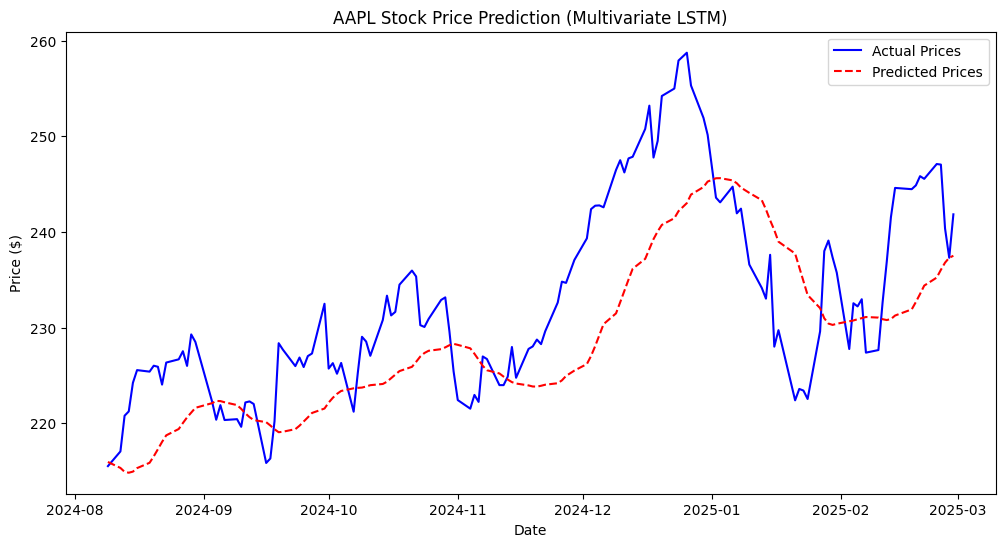

RMSE for AAPL: 7.97

Training Multivariate LSTM for AMD...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0456 - val_loss: 0.0068
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_l

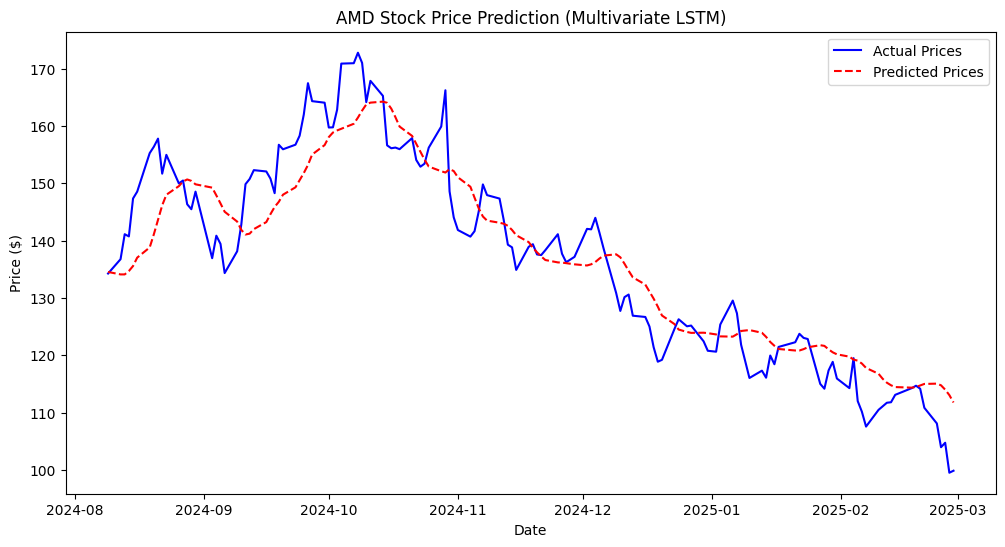

RMSE for AMD: 6.62

Training Multivariate LSTM for NVDA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0222 - val_loss: 0.0051
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0087
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0066
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_l

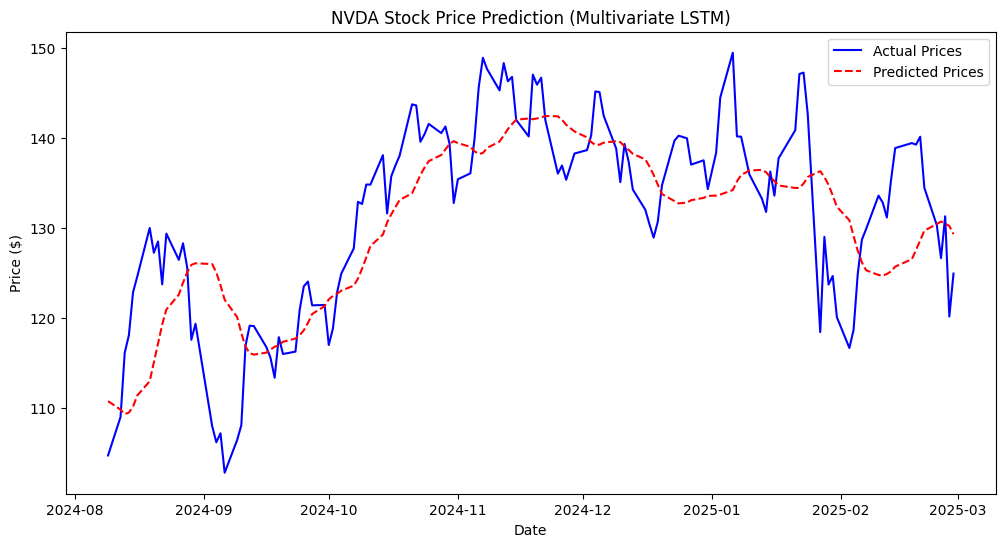

RMSE for NVDA: 7.45

Training Multivariate LSTM for TSM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0203 - val_loss: 0.0237
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050 - val_loss: 0.0228
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0241
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027 - val_loss: 0.0270
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0161
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 0.0132
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0214
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0264
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0152
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 0.0139
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_

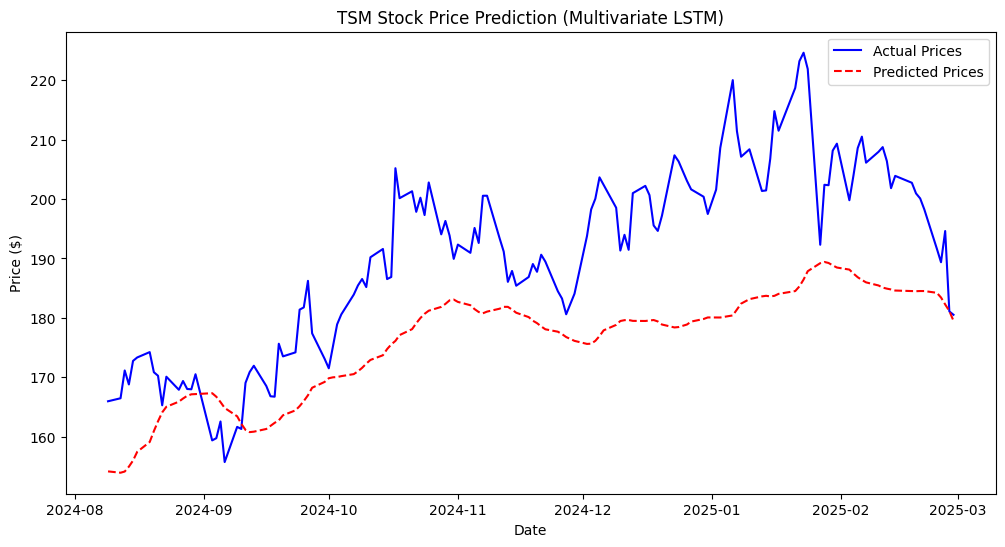

RMSE for TSM: 17.08

Training Multivariate LSTM for GOOG...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0514 - val_loss: 0.0545
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_l

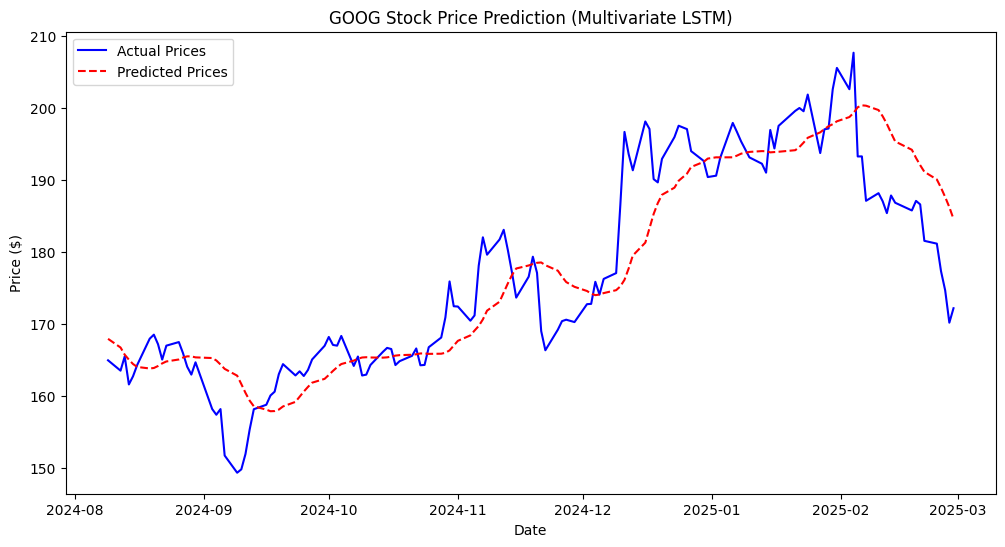

RMSE for GOOG: 6.54

Training Multivariate LSTM for MSFT...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1033 - val_loss: 0.0310
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0123 - val_loss: 0.0032
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_l

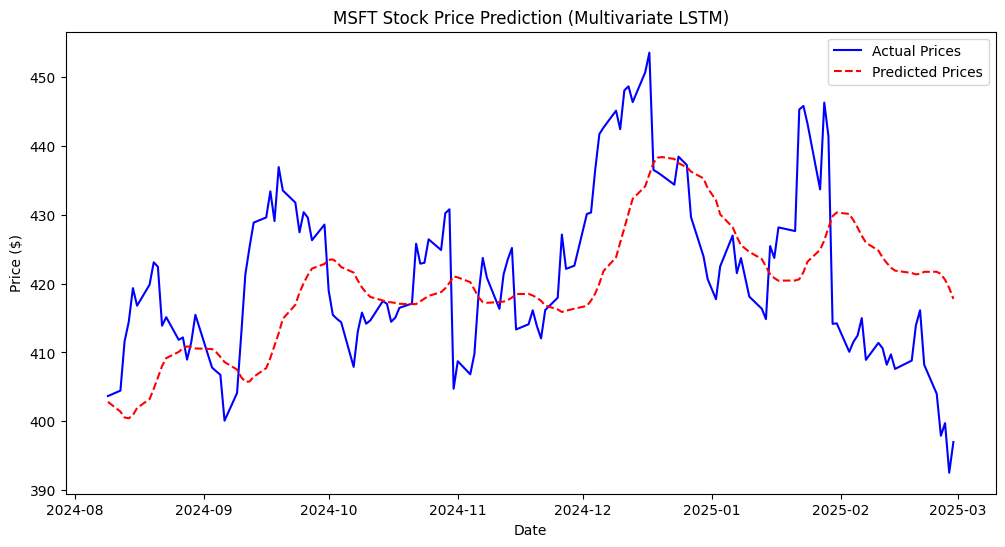

RMSE for MSFT: 12.25

Training Multivariate LSTM for AMZN...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0496 - val_loss: 0.0607
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0155
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_l

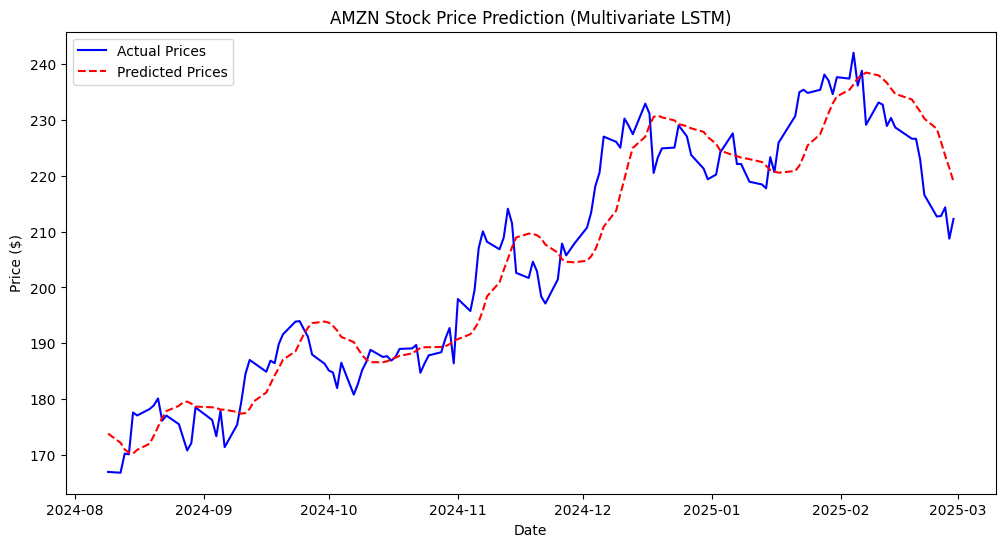

RMSE for AMZN: 6.65

Training Multivariate LSTM for META...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0408 - val_loss: 0.0658
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057 - val_loss: 0.0378
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0170
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0099
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0119
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_l

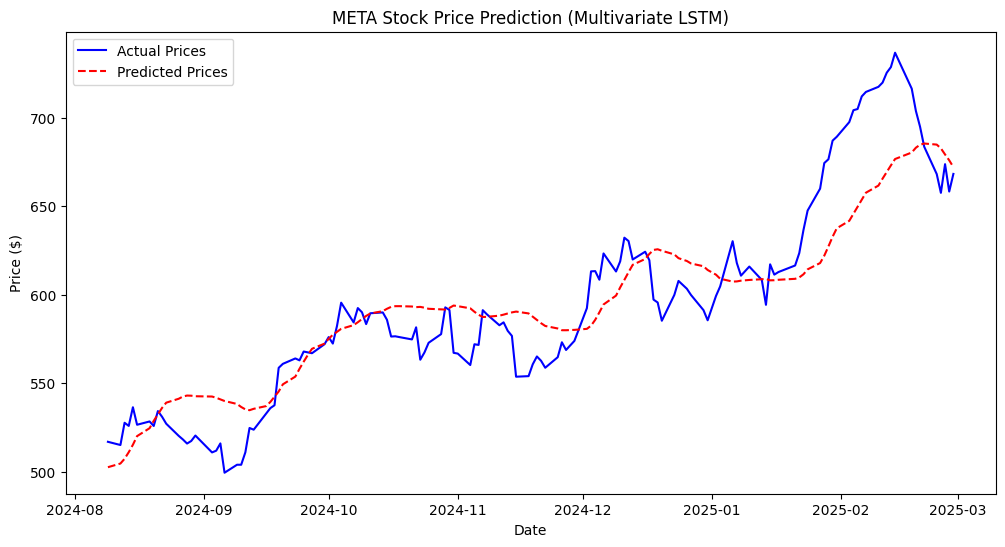

RMSE for META: 24.88

Training Multivariate LSTM for TSLA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0559 - val_loss: 0.0746
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062 - val_loss: 0.0537
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0375
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0196
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0100
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0094
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_l

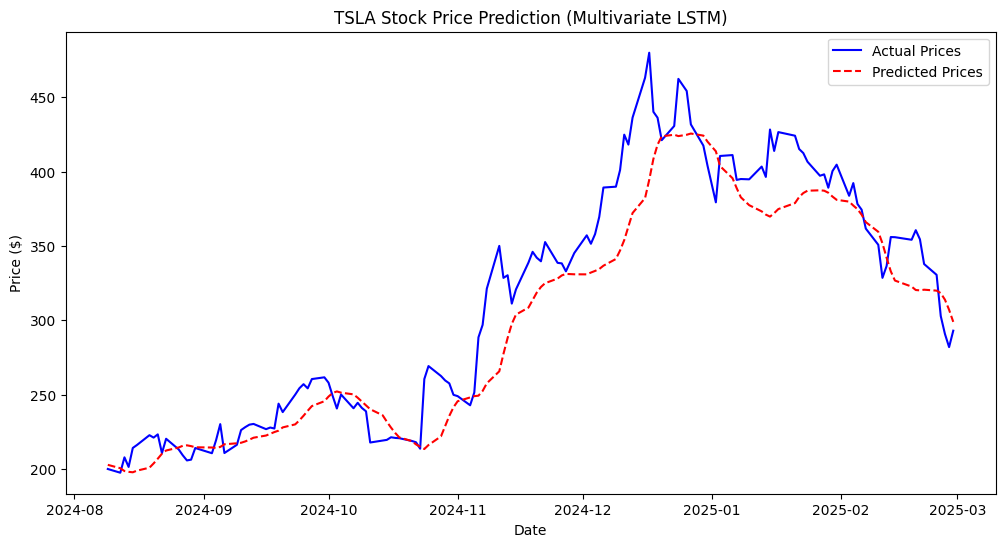

RMSE for TSLA: 27.35

Training Multivariate LSTM for QCOM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0532 - val_loss: 0.0027
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0095 - val_loss: 0.0021
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


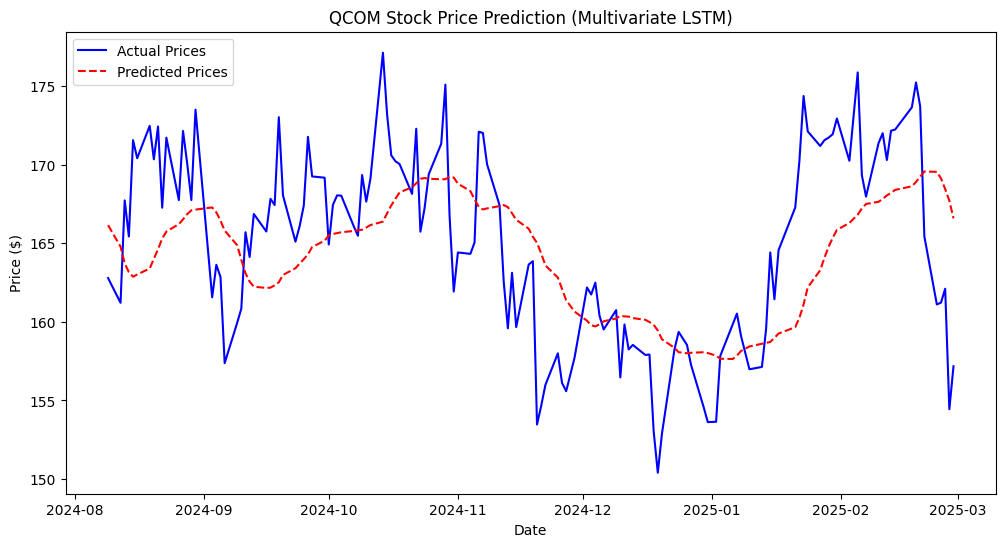

RMSE for QCOM: 5.20


In [48]:
import yfinance as yf
from sklearn.metrics import mean_squared_error

# Fetch historical stock data (last 3 years)
tickers = ["AAPL", "AMD", "NVDA", "TSM", "GOOG", "MSFT", "AMZN", "META", "TSLA", "QCOM"]
data = yf.download(tickers, period="3y", interval="1d")['Close']  # Only use closing prices

# Store RMSE scores and predictions
rmse_scores = {}
predicted_values = {}

# Define related stocks
related_stocks_map = {
    "AAPL": ["GOOG", "META"],
    "AMD": ["NVDA"],
    "NVDA": ["AMD"],
    "TSM": ["NVDA", "AMD", "QCOM"],
    "GOOG": ["AMZN"],
    "MSFT": ["AAPL", "GOOG", "META"],
    "AMZN": ["GOOG"],
    "META": ["GOOG", "MSFT"],
    "TSLA": ["NVDA", "QCOM"],
    "QCOM": ["TSM", "NVDA"]
}

# Train models for each stock
for ticker in tickers:
    related_stocks = related_stocks_map[ticker]
    print(f"\nTraining Multivariate LSTM for {ticker}...")

    lstm_model = MultivariateStockLSTM(ticker, related_stocks, data)
    lstm_model.train_model(epochs=50, batch_size=32)
    lstm_model.predict_test_set()

    rmse_scores[ticker] = lstm_model.compute_rmse()
    predicted_values[ticker] = lstm_model.predictions


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Training Univariate and Multivariate LSTM for AAPL...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0594 - val_loss: 0.0726
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0094 - val_loss: 0.0139
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0053
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_l

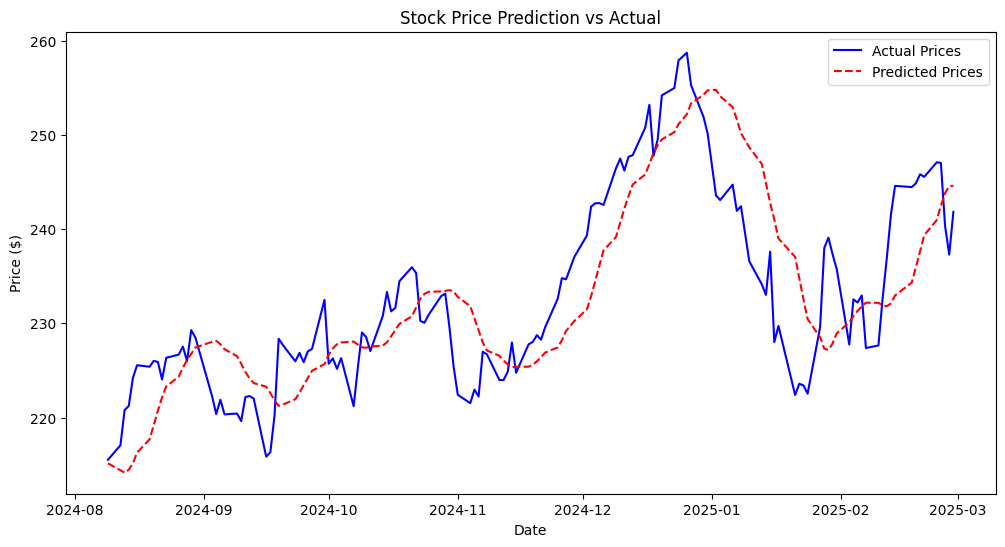

RMSE: 6.14
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0442 - val_loss: 0.0651
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - val_loss: 0.0418
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - val_loss: 0.0233
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - val_loss: 0.0127
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 11: early stopping
Restoring model weights from the end of the best 

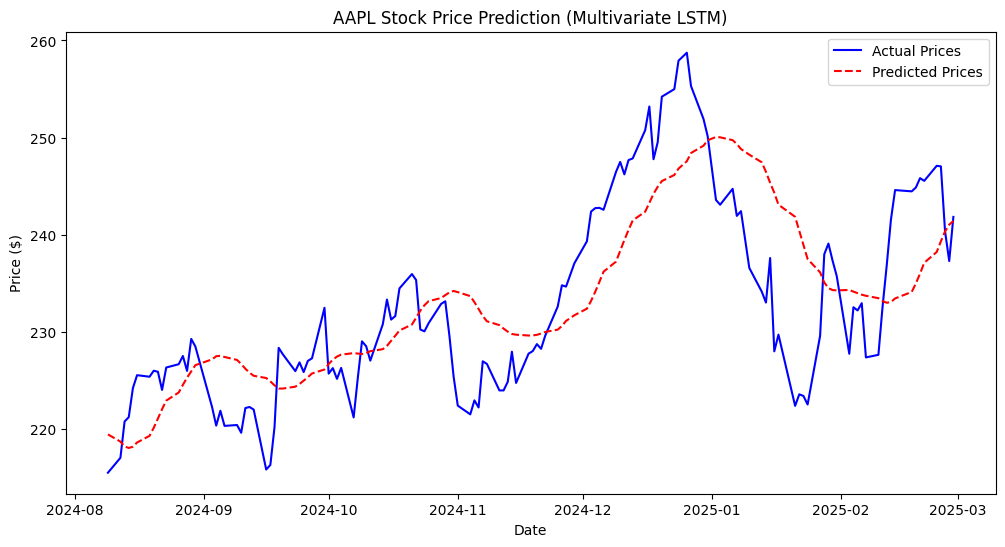

RMSE for AAPL: 6.78

Training Univariate and Multivariate LSTM for AMD...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0601 - val_loss: 0.0136
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_l

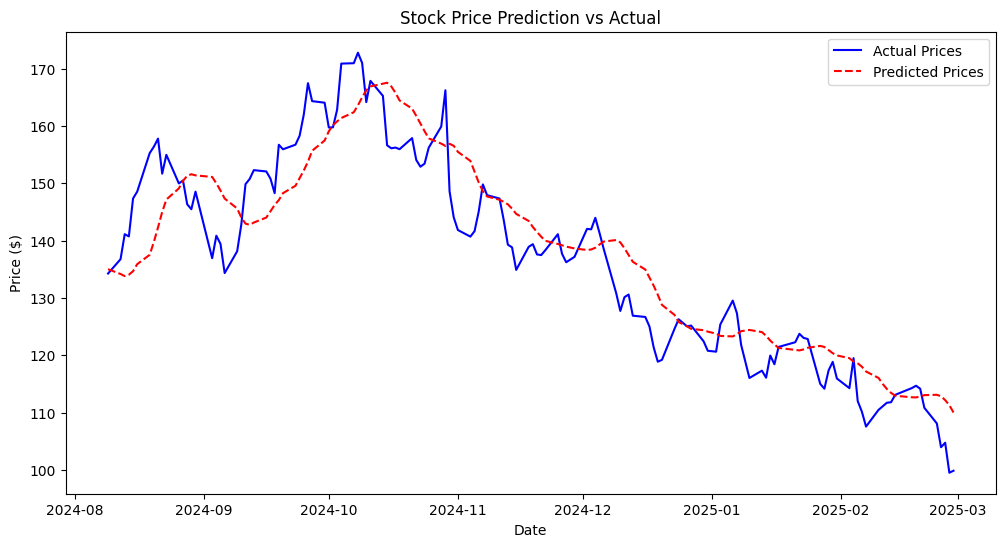

RMSE: 7.13
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0894 - val_loss: 0.0103
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170 - val_loss: 0.0668
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - val_loss: 0.0355
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043 - val_loss: 0.0118
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - val_l

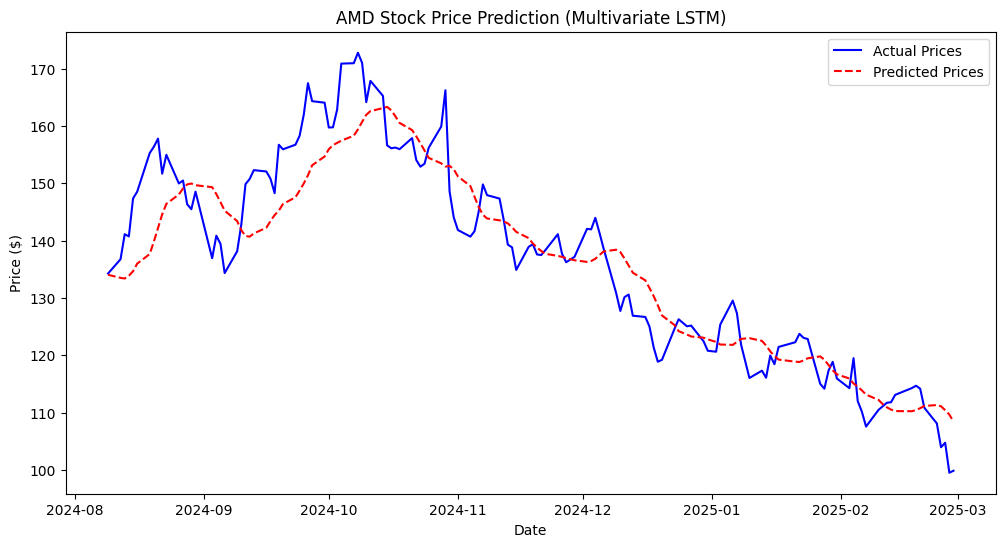

RMSE for AMD: 6.77

Training Univariate and Multivariate LSTM for NVDA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0550 - val_loss: 0.0448
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052 - val_loss: 0.0094
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 0.0112
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


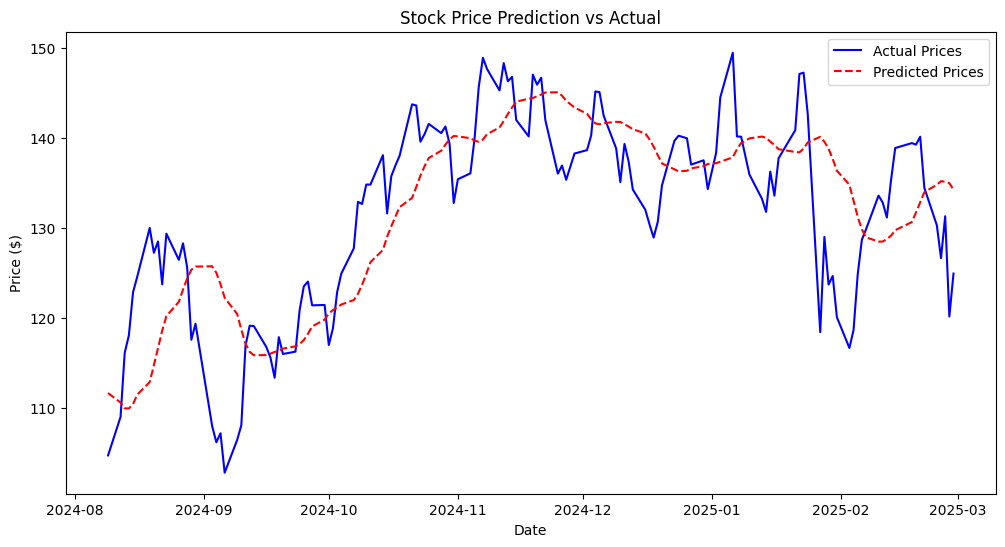

RMSE: 7.70
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0606 - val_loss: 0.0581
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0117
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_l

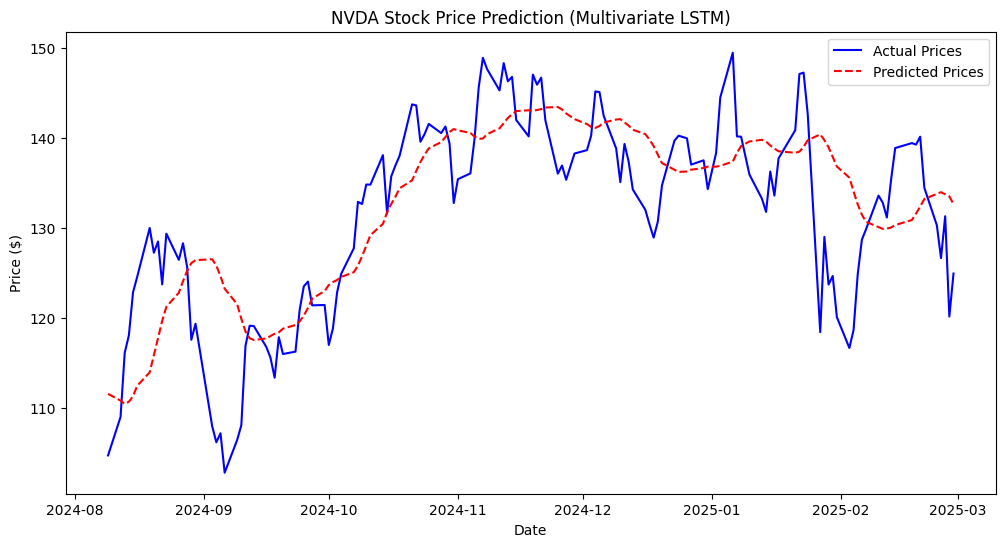

RMSE for NVDA: 7.46

Training Univariate and Multivariate LSTM for TSM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0372 - val_loss: 0.0606
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


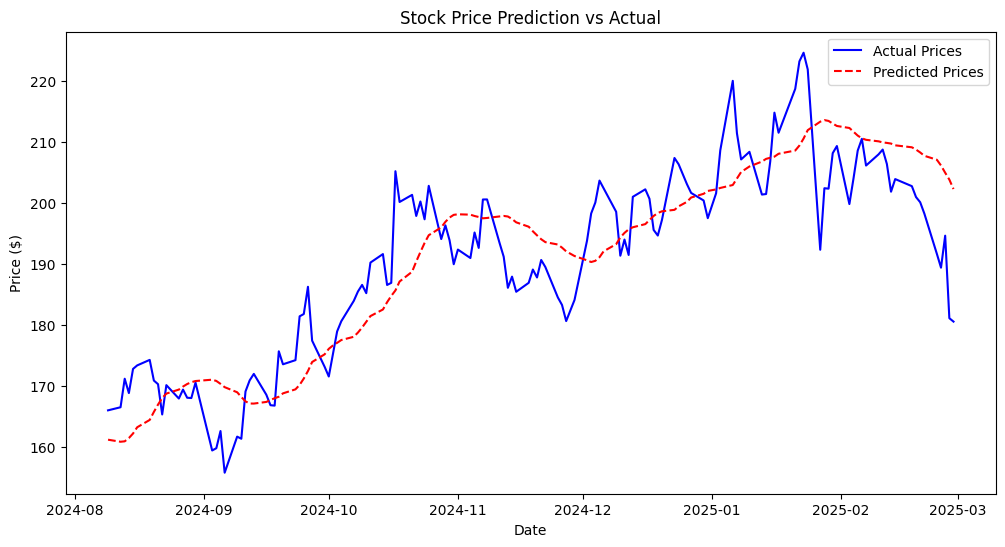

RMSE: 8.06
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0223 - val_loss: 0.0331
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0053 - val_loss: 0.0217
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0070
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


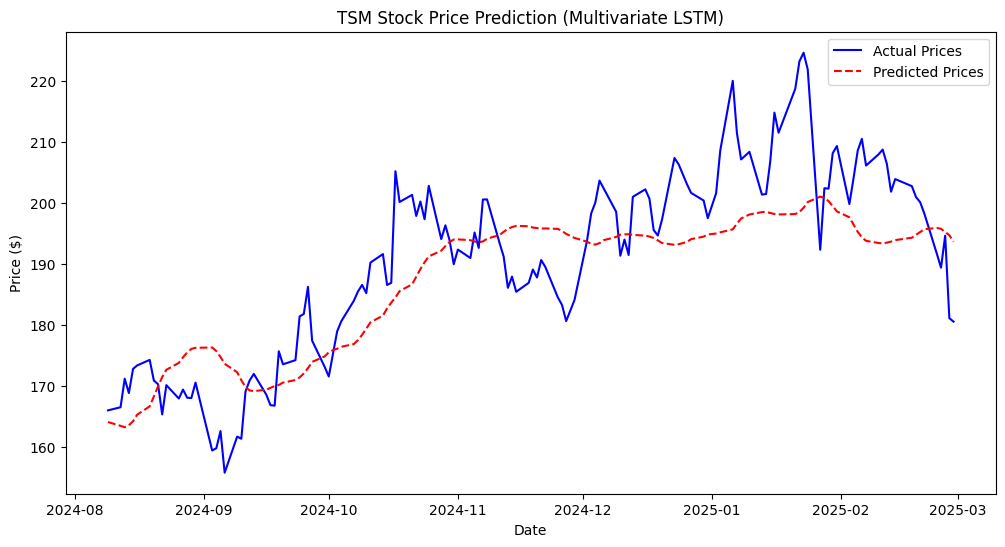

RMSE for TSM: 9.47

Training Univariate and Multivariate LSTM for GOOG...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0617 - val_loss: 0.0393
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_l

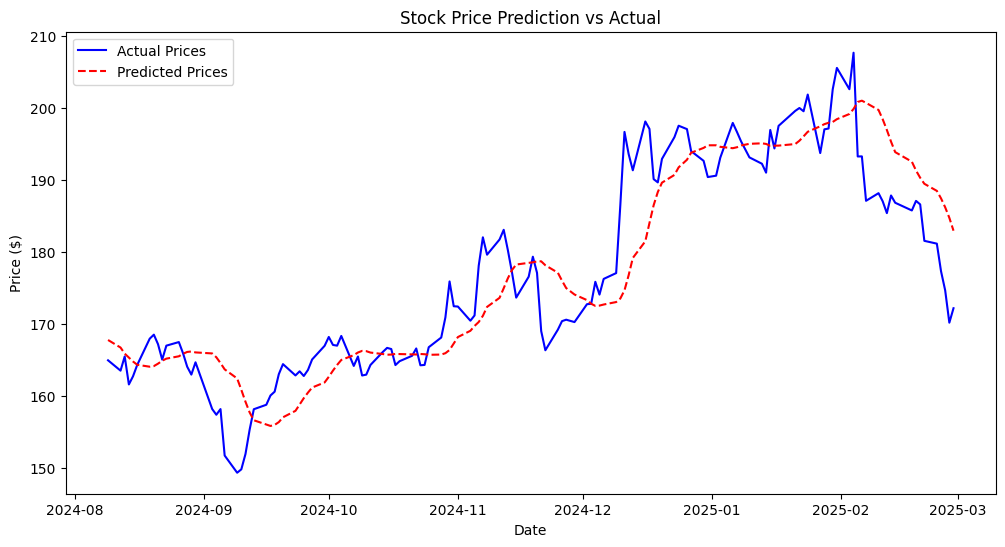

RMSE: 6.37
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0726 - val_loss: 0.0420
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0082 - val_loss: 0.0154
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 11: early stopping
Restoring model weights from the end of the best 

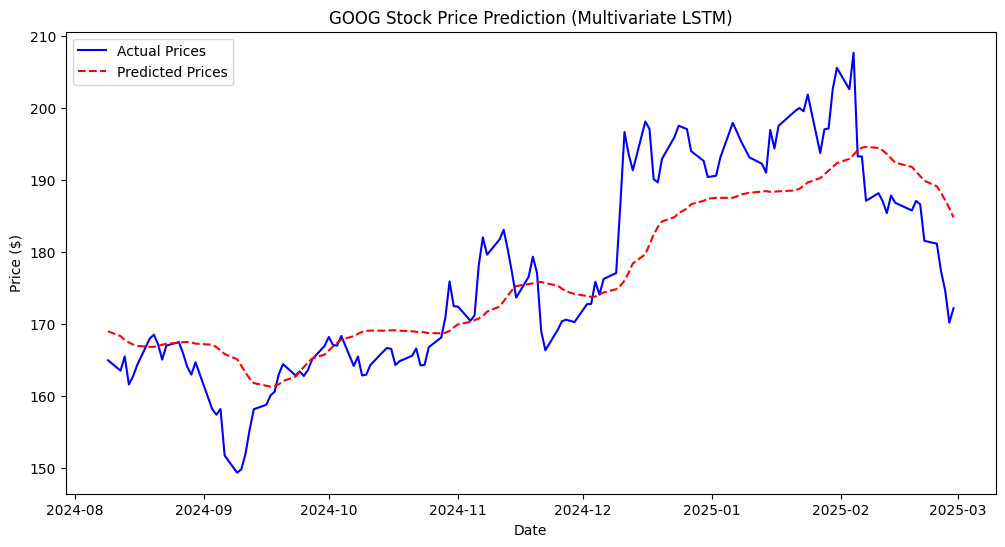

RMSE for GOOG: 7.30

Training Univariate and Multivariate LSTM for MSFT...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0677 - val_loss: 0.0281
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_l

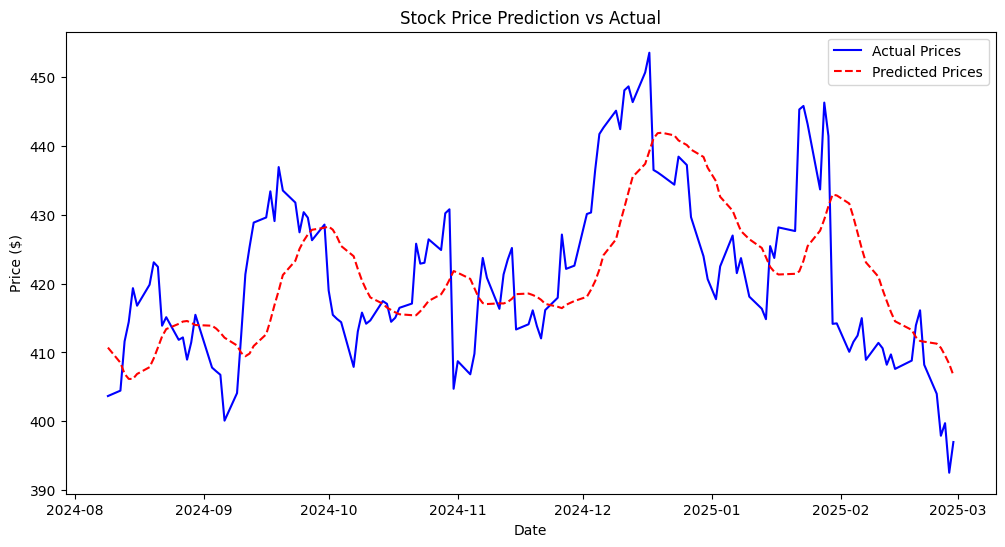

RMSE: 10.45
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1231 - val_loss: 0.0348
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0184 - val_loss: 0.0066
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0084 - val_loss: 0.0045
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 0.0089
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_l

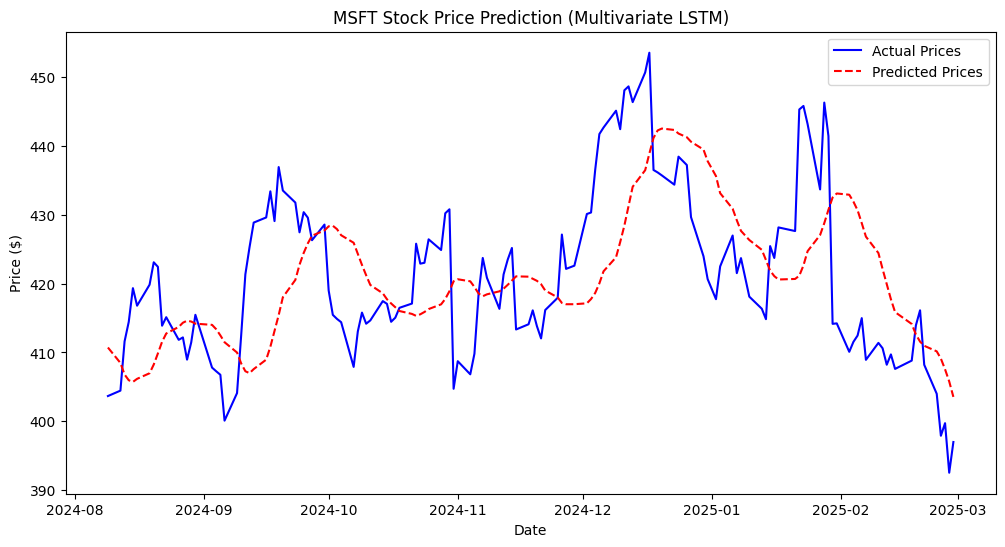

RMSE for MSFT: 11.43

Training Univariate and Multivariate LSTM for AMZN...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0322 - val_loss: 0.0339
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_l

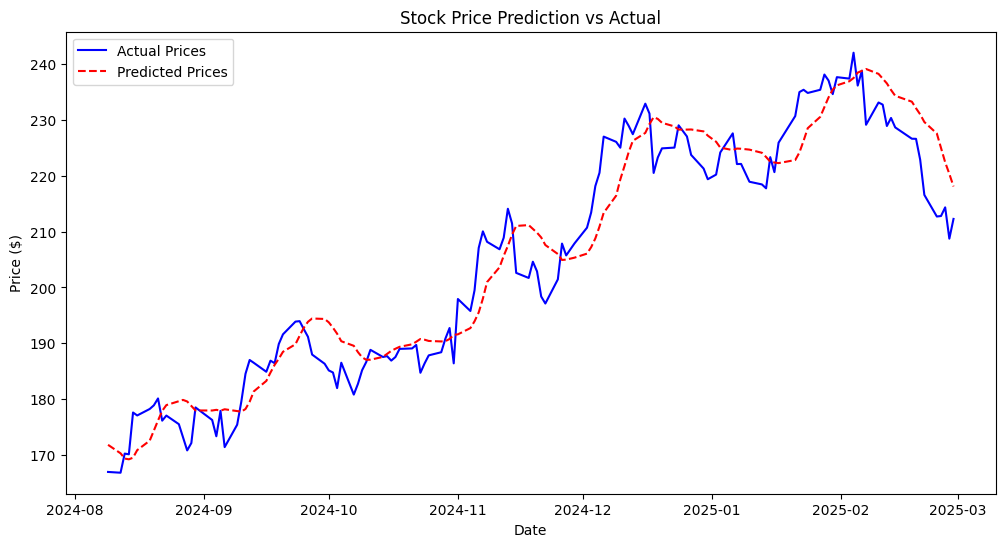

RMSE: 5.97
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0531 - val_loss: 0.0667
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_loss: 0.0288
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0190
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0120
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0115
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0112
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 0.0113
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_l

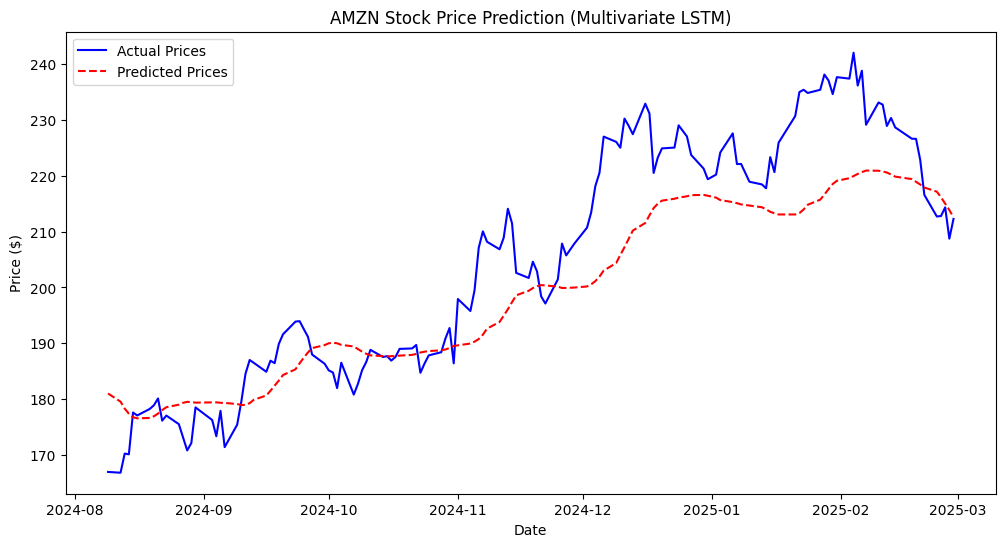

RMSE for AMZN: 10.43

Training Univariate and Multivariate LSTM for META...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0586 - val_loss: 0.0626
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - val_loss: 0.0066
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_l

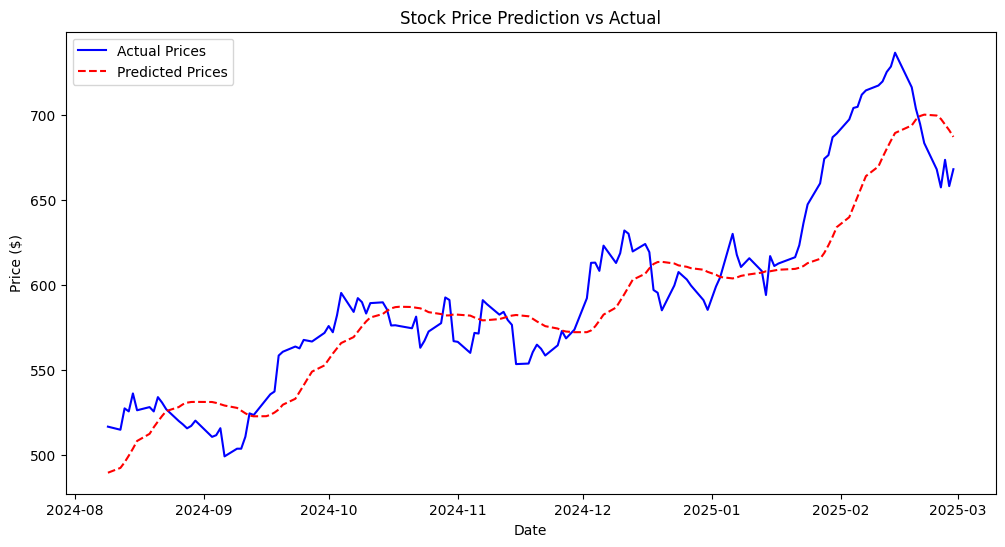

RMSE: 24.67
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0263 - val_loss: 0.0192
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038 - val_loss: 0.0129
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0105
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0184
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0073
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0113
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


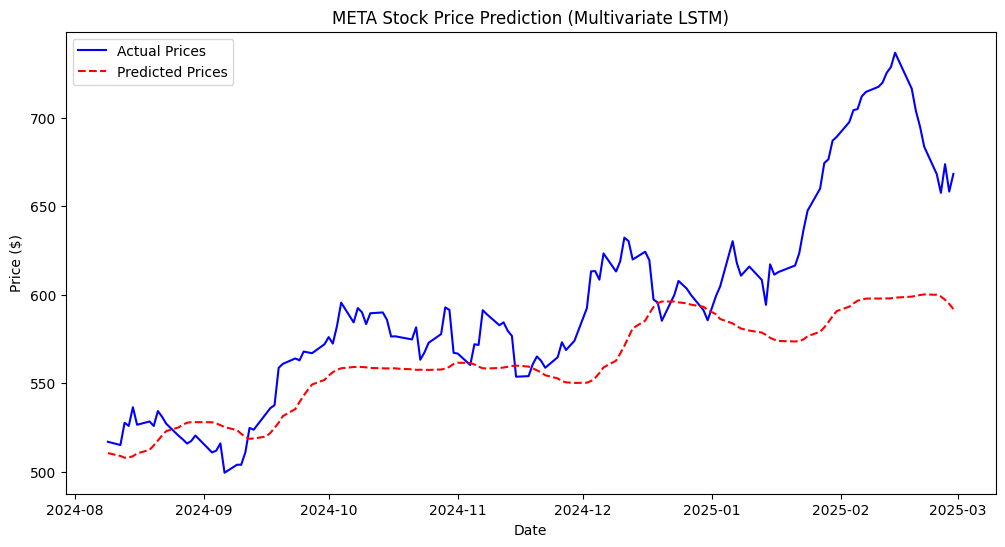

RMSE for META: 49.34

Training Univariate and Multivariate LSTM for TSLA...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0408 - val_loss: 0.0543
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0279
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_l

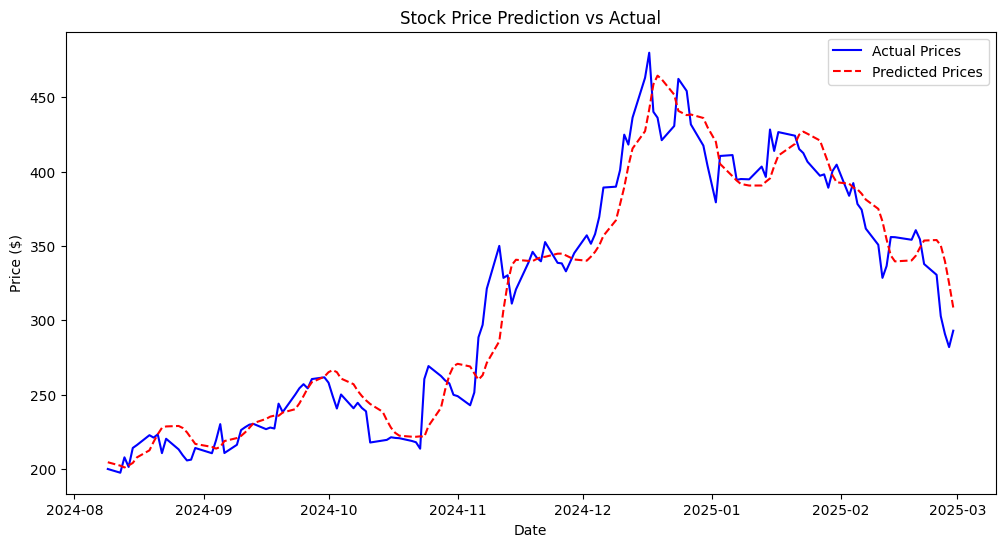

RMSE: 19.16
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0275 - val_loss: 0.0302
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0155
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - val_loss: 0.0155
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 0.0174
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 0.0102
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 0.0078
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0074
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0068
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


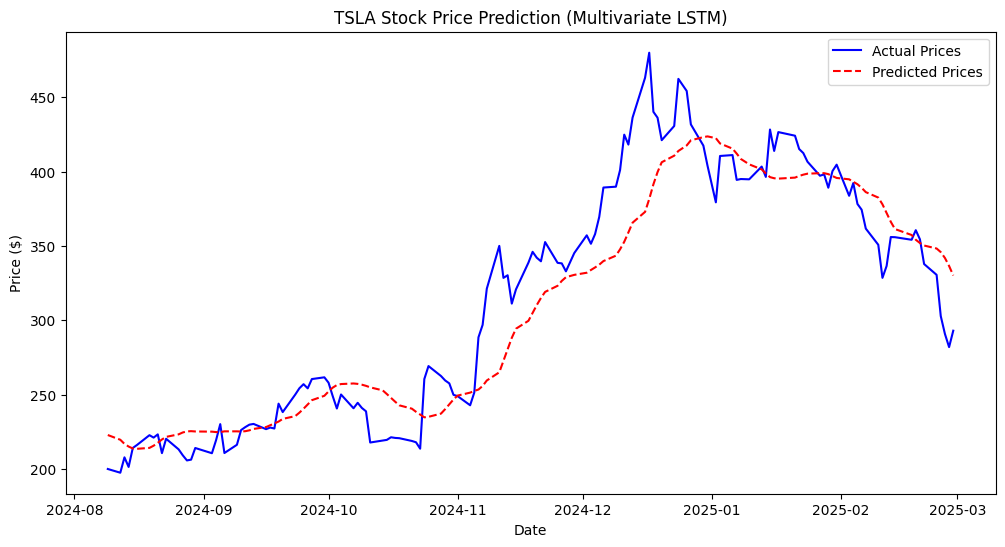

RMSE for TSLA: 28.75

Training Univariate and Multivariate LSTM for QCOM...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0407 - val_loss: 0.0166
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0082 - val_loss: 0.0021
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 11: early stopping
Restoring model weights from the end of the best 

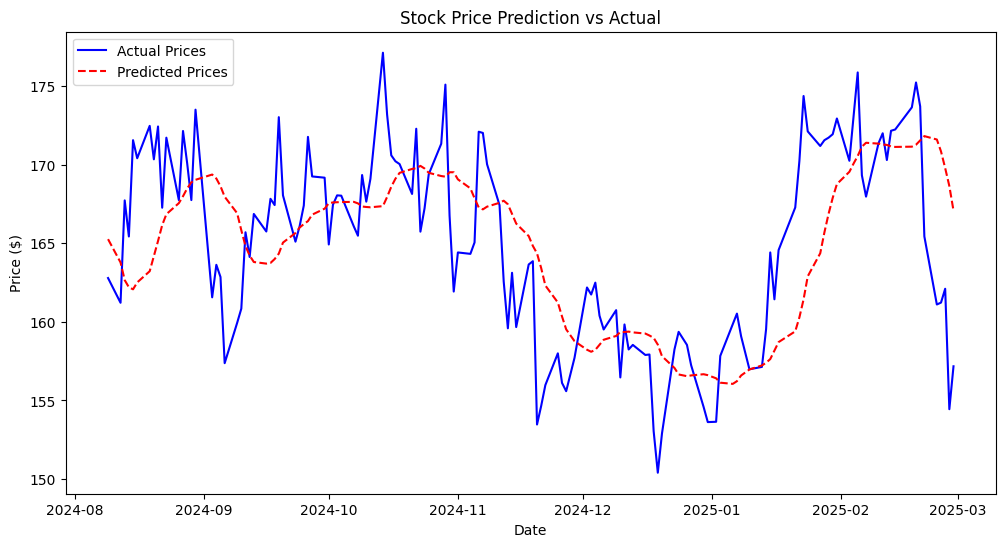

RMSE: 4.90
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0549 - val_loss: 0.0049
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - val_loss: 0.0138
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0048 - val_loss: 0.0065
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_l

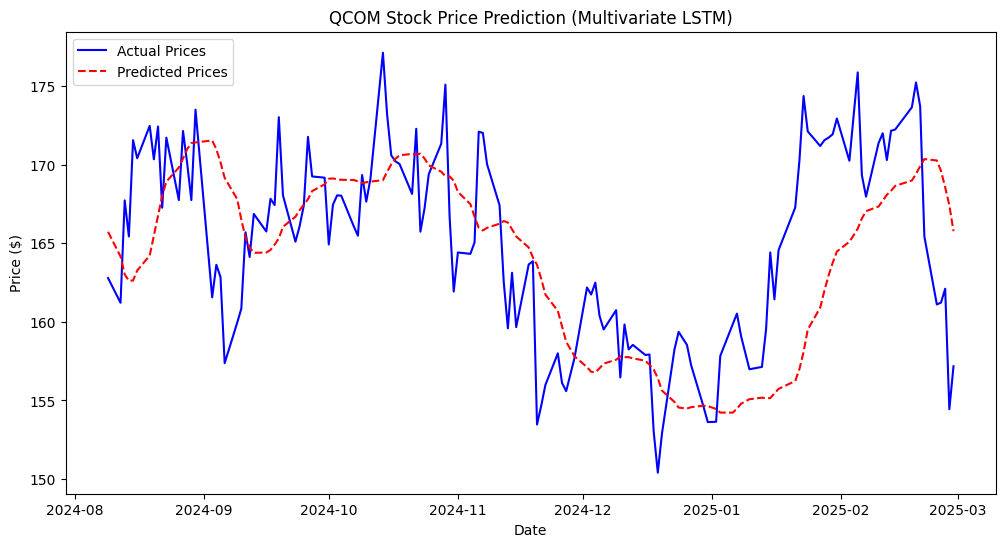

RMSE for QCOM: 5.42

✅ Training Complete for All Stocks!


In [40]:
# Dictionaries to store results
rmse_scores_univariate = {}
rmse_scores_multivariate = {}
predictions_univariate = {}
predictions_multivariate = {}

# Train and compare Univariate vs Multivariate LSTMs
for ticker in tickers:
    related_stocks = related_stocks_map[ticker]
    print(f"\nTraining Univariate and Multivariate LSTM for {ticker}...")

    # Train Univariate LSTM (Closing price only)
    uni_lstm = StockLSTM(data[ticker])
    uni_lstm.train_model(epochs=50, batch_size=32)
    uni_lstm.predict_test_set()
    rmse_scores_univariate[ticker] = uni_lstm.compute_rmse()
    predictions_univariate[ticker] = uni_lstm.predictions

    # Train Multivariate LSTM (Closing price + related stocks)
    multi_lstm = MultivariateStockLSTM(ticker, related_stocks, data)
    multi_lstm.train_model(epochs=50, batch_size=32)
    multi_lstm.predict_test_set()
    rmse_scores_multivariate[ticker] = multi_lstm.compute_rmse()
    predictions_multivariate[ticker] = multi_lstm.predictions

print("\n✅ Training Complete for All Stocks!")


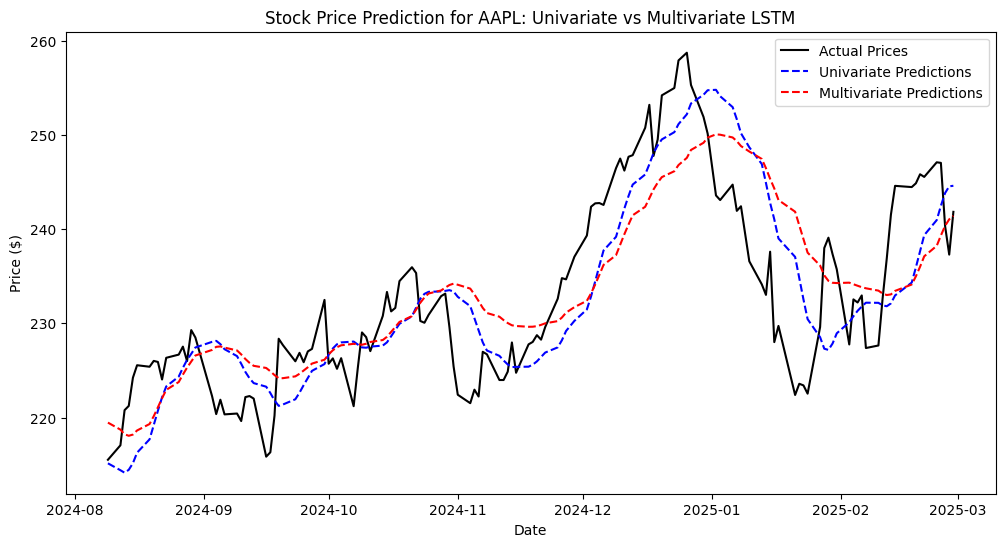

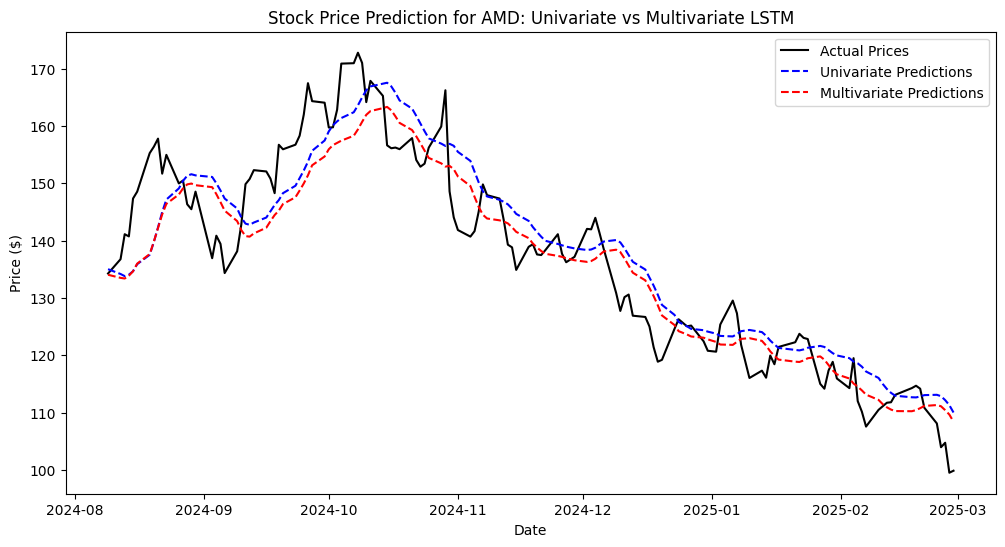

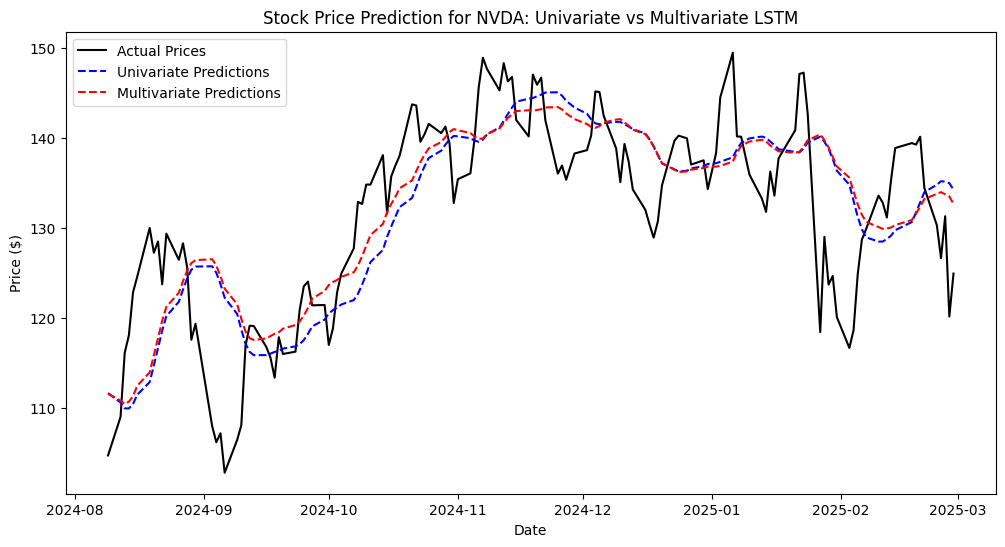

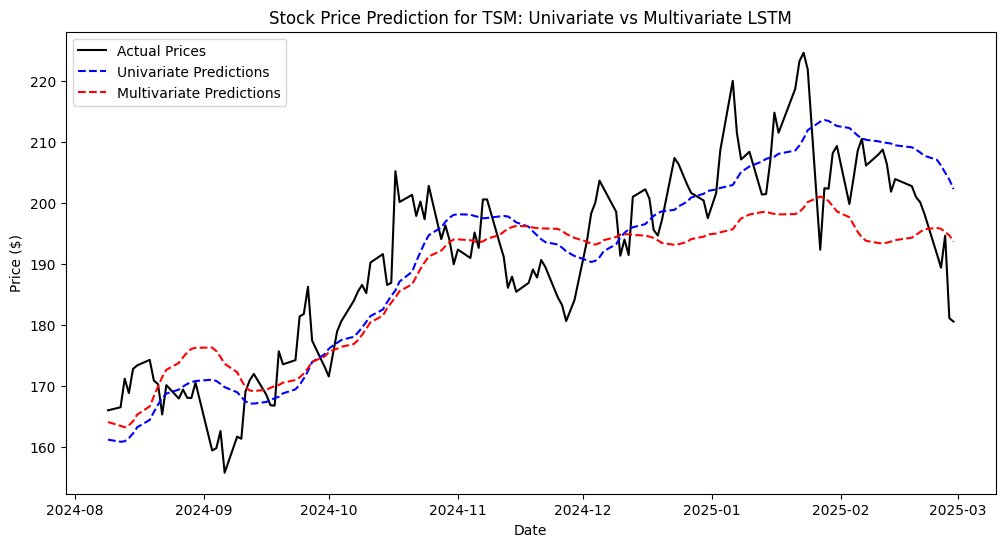

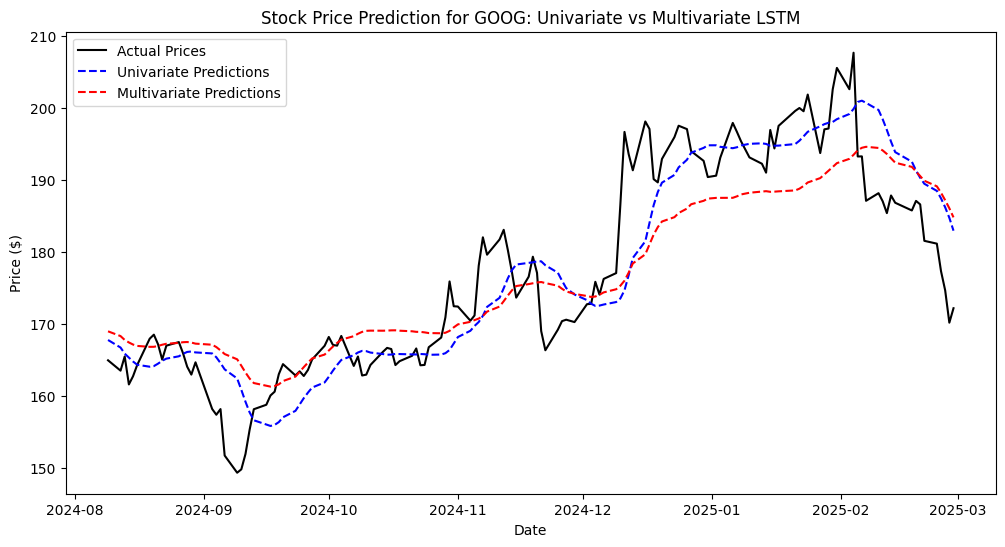

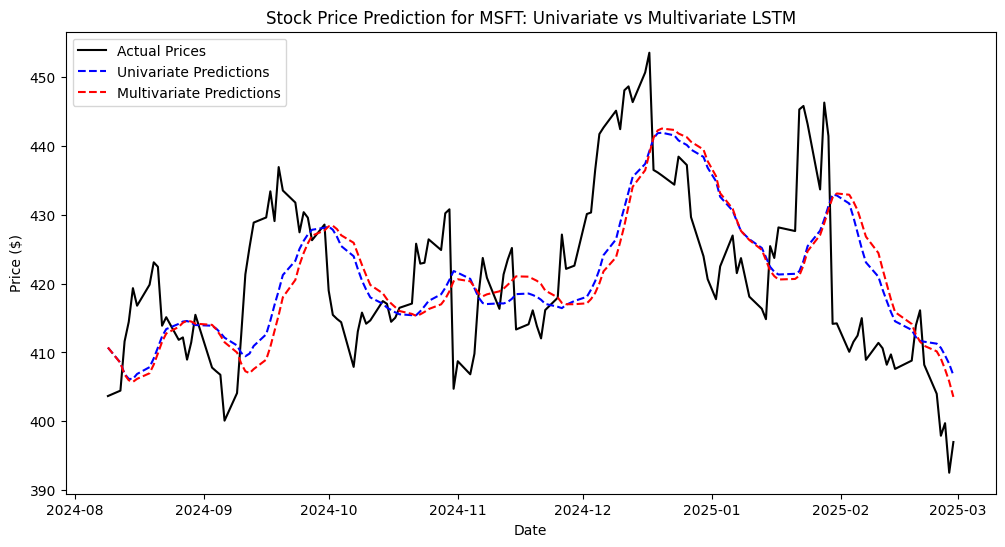

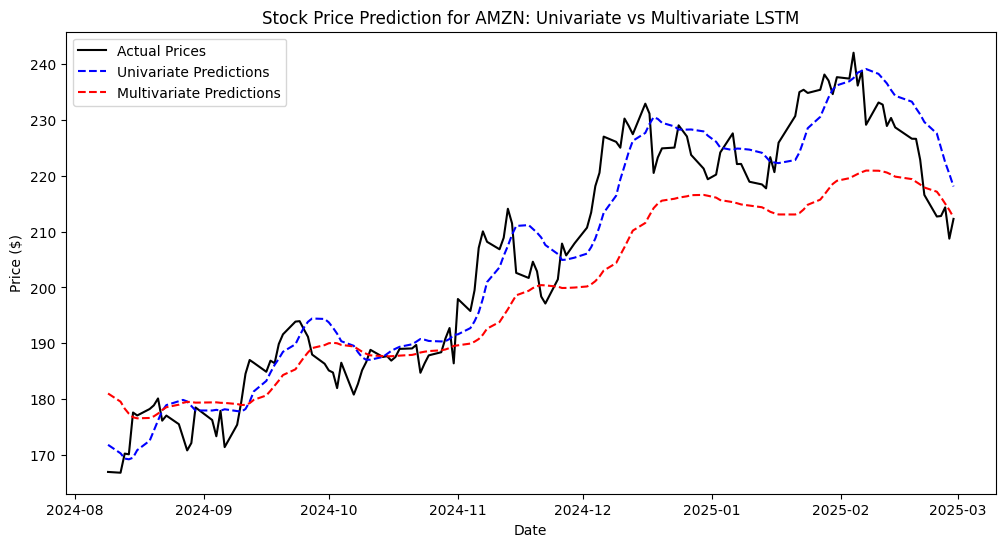

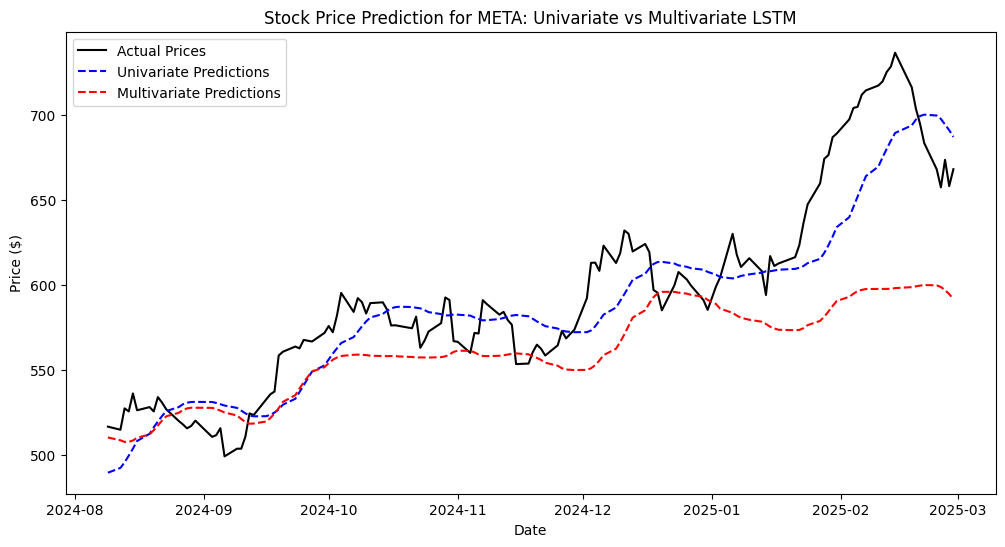

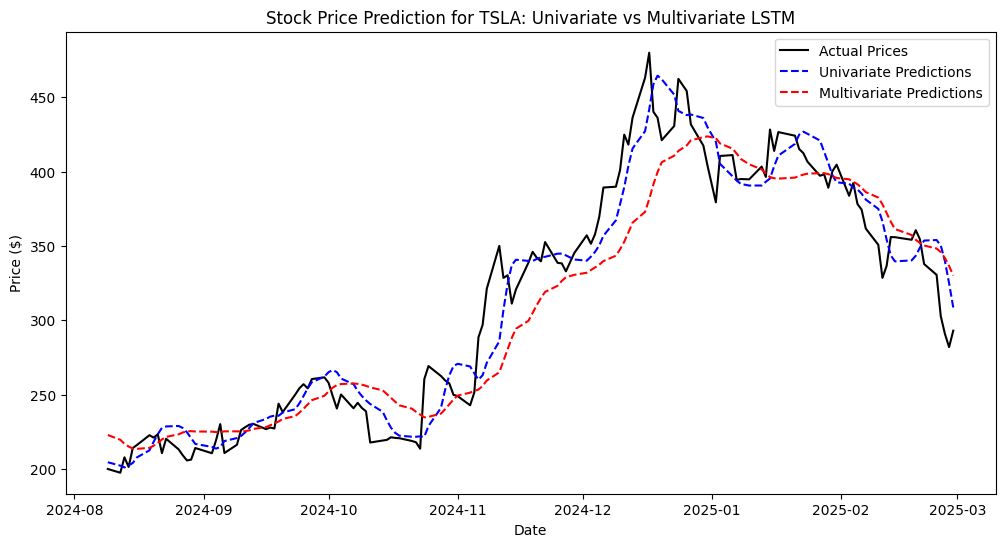

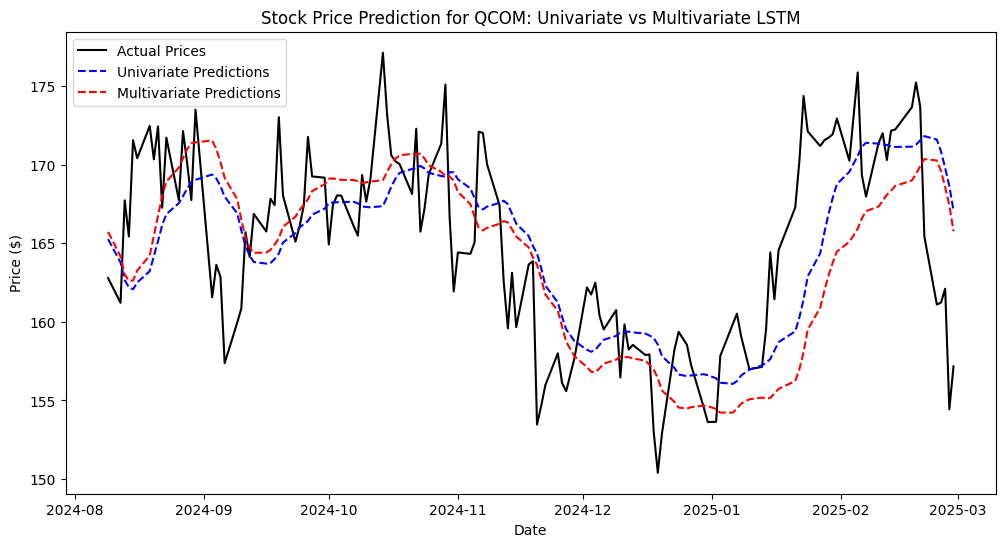

In [46]:
import matplotlib.pyplot as plt

def plot_prediction_comparison(ticker):
    plt.figure(figsize=(12,6))

    # Plot Actual Prices
    plt.plot(data[ticker].index[-len(predictions_univariate[ticker]):],
             data[ticker].values[-len(predictions_univariate[ticker]):],
             label="Actual Prices", color="black")

    # Plot Univariate Predictions
    plt.plot(data[ticker].index[-len(predictions_univariate[ticker]):],
             predictions_univariate[ticker],
             label="Univariate Predictions", linestyle="dashed", color="blue")

    # Plot Multivariate Predictions
    plt.plot(data[ticker].index[-len(predictions_multivariate[ticker]):],
             predictions_multivariate[ticker],
             label="Multivariate Predictions", linestyle="dashed", color="red")

    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.title(f"Stock Price Prediction for {ticker}: Univariate vs Multivariate LSTM")
    plt.legend()
    plt.show()

# Example: Compare AAPL Predictions
for ticker in tickers:
  plot_prediction_comparison(ticker)


In [47]:
correlation_matrix = data.corr()

# Display the correlation matrix
print("\n📊 Stock Correlation Matrix:")
print(correlation_matrix)


📊 Stock Correlation Matrix:
Ticker      AAPL       AMD      AMZN      GOOG      META      MSFT      NVDA  \
Ticker                                                                         
AAPL    1.000000  0.630763  0.873389  0.894790  0.904035  0.876315  0.911489   
AMD     0.630763  1.000000  0.722513  0.739534  0.776354  0.885790  0.733530   
AMZN    0.873389  0.722513  1.000000  0.961654  0.934232  0.895070  0.907421   
GOOG    0.894790  0.739534  0.961654  1.000000  0.937337  0.926605  0.928033   
META    0.904035  0.776354  0.934232  0.937337  1.000000  0.949501  0.965223   
MSFT    0.876315  0.885790  0.895070  0.926605  0.949501  1.000000  0.922515   
NVDA    0.911489  0.733530  0.907421  0.928033  0.965223  0.922515  1.000000   
QCOM    0.658990  0.762079  0.810997  0.818935  0.770867  0.790816  0.814726   
TSLA    0.504642 -0.018413  0.523731  0.443566  0.325099  0.218548  0.303414   
TSM     0.899065  0.675437  0.919674  0.921466  0.946393  0.872937  0.976179   

Ticker    

In [49]:
!pip install transformers safetensors torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [50]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load model from SafeTensors
model_path = "model.safetensors"  # Update with actual file path if needed
model = AutoModelForSequenceClassification.from_pretrained(model_path, from_safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("✅ Sentiment analysis model loaded successfully!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: model.safetensors is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`